# Load Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
from sklearn.metrics import classification_report
from os import chdir
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import numpy as np
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import datetime
import numpy as np
import pandas as pd
import datetime
import pickle
import keras
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
from sklearn.model_selection import train_test_split
from keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import random
from tqdm import tqdm
from tensorflow.keras.layers import Dense, Flatten,Activation, Dropout, ZeroPadding3D,BatchNormalization, Bidirectional, GRU
from keras.layers.recurrent import LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.layers.wrappers import TimeDistributed
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc
random_state = 5
random.seed(random_state)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Functions

## Evaluation Functions

In [4]:
def evaluate(y_test, y_pred, mode='categorical'):
  if mode=='categorical':
    y_t = np.argmax(y_test,axis=1)
    y_p = np.argmax(y_pred,axis=1)
  else:
    y_t = y_test
    y_p = y_pred
  accuracy= accuracy_score(y_t, y_p)

  cf= confusion_matrix(y_t, y_p)

  precision= precision_score(y_t, y_p)

  recall = recall_score(y_t, y_p)

  fscore= f1_score(y_t, y_p)
  target_names = ['Non Fall', 'Fall']
  print(classification_report(y_t, y_p, target_names=target_names))
  
  return accuracy, cf, precision, recall, fscore

def cf_plot(y_test, y_pred, mode='categorical'):
  if mode=='categorical':
    y_test = np.argmax(y_test,axis=1)
    y_pred = np.argmax(y_pred,axis=1)
  cf= confusion_matrix(y_test, y_pred)
  ax = sns.heatmap(cf, annot=True, cmap='Blues')

  ax.set_title('Confusion Matrix\n\n');
  ax.set_xlabel('\nPredicted Labels')
  ax.set_ylabel('True Labels');
  ax.xaxis.set_ticklabels(['Non Fall','Fall'])
  ax.yaxis.set_ticklabels(['Non Fall','Fall'])
  plt.show() 

def roc_auc_plot(y_test, y_pred):
  
  y_test = y_test[:][1]
  y_pred = y_pred[:][1]
  fpr, tpr, threshold = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train Acc', 'Val Acc'], loc='lower right')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train loss', 'Val loss'], loc='upper right')
  plt.show()

## Data Loading, Processing, Model loading and Helper Functions

In [5]:
def load_data(dataset_name = 'urfd'):
  if dataset_name == 'urfd':
    data = np.load('drive/MyDrive/urfd_16_segmented/data(224).npy')
    label = np.load('drive/MyDrive/urfd_16_segmented/label(224).npy') 
    return data,label
  elif dataset_name == 'mcfd':
    data = np.load('drive/MyDrive/mcfd_new_16_segmented/data.npy')
    label = np.load('drive/MyDrive/mcfd_new_16_segmented/label.npy')
    return data,label 
  else:
    raise ValueError('Invalid Dataset')

In [6]:
def load_feature_extractor(model='VGG16'):
  if model=='VGG16':
    base_model = tf.keras.applications.VGG16(
      weights="imagenet",
      input_shape=(224,224,3)
    )
  elif model=='VGG19':
    base_model = tf.keras.applications.VGG19(
      weights="imagenet",
      input_shape=(224,224,3)
    )
  x = base_model.layers[-2].output
  cnn_model = Model(inputs=base_model.input, outputs=x)
  return cnn_model

def extract_features_process_label(data,label,dataset_name,model='VGG19',classification='categorical'):
  if os.path.exists('drive/MyDrive/Colab Notebooks/Data/'+dataset_name+'_feature_data_224('+model+').npy'):
    X = np.load('drive/MyDrive/Colab Notebooks/Data/'+dataset_name+'_feature_data_224('+model+').npy')
  else:
    feature_extractor = load_feature_extractor(model)
    X = []
    for video in tqdm(data):
      v = []
      for img in video:
          #img = img / 255
          img = feature_extractor.predict(img.reshape(1,224,224,3))
          v.append(img.reshape(feature_extractor.output.shape[1]))
      X.append(v)
    X = np.array(X)
    np.save('drive/MyDrive/Colab Notebooks/Data/'+dataset_name+'_feature_data_224('+model+').npy',X)
  
  if classification=='categorical':
    label = tf.keras.utils.to_categorical(
      label, num_classes=None, dtype='float32'
      )
  return X,label

In [7]:
def create_classification_model(input_shape=(16,4096),classes=2,m_type='lstm',n_neuron=2048,activation='softmax'):
  model = Sequential()
  if m_type=='lstm':
    model.add(LSTM(n_neuron, return_sequences=False,
                  input_shape=input_shape,
                  dropout=0.5))
  elif m_type=='gru':
    model.add(GRU(n_neuron, return_sequences=False,
                        input_shape=input_shape,
                        dropout=0.5))
  elif m_type=='bilstm':
    model.add(Bidirectional(LSTM(n_neuron, return_sequences=False,
                        input_shape=input_shape,
                        dropout=0.5)))
  elif m_type=='bigru':
    model.add(Bidirectional(GRU(n_neuron, return_sequences=False,
                        input_shape=input_shape,
                        dropout=0.5)))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(classes, activation=activation))
  return model

In [8]:
def compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.001):
  if optimizer=='adam':
    optm = Adam(learning_rate=learning_rate, decay=1e-6)
  elif optimizer=='sgd':
    optm = SGD(learning_rate=learning_rate, momentum=0.0, nesterov=False, name="SGD",)
  elif optimizer=='rmsprop':
    optm = RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-07)
  model.compile(loss=loss, optimizer=optm,
                           metrics=["accuracy"])
  return model

In [9]:
def train_model(model,x_train,x_val,y_train, y_val,batch_size=16,n_epoch=1):
  history = model.fit(
              x_train,
              y_train,
              batch_size=batch_size,
              validation_data=(x_val, y_val),
              verbose=1,
              epochs=n_epoch)
  return history,model

In [10]:
def train_val_test_split(X,y,train_size = 0.6):
  X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=train_size, random_state=random_state)
  X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=random_state)
  return X_train, X_valid, X_test, y_train, y_valid, y_test

# MAIN

## URFD

### Optimizer and Learning Rate

In [ ]:
data,label = load_data('urfd')
x,y = extract_features_process_label(data,label,dataset_name='urfd',model='VGG16',classification='categorical')
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(x,y,train_size=0.6)
#model.summary()

#### adam

##### 0.1

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.1)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
6/6 [==============================] - 9s 167ms/step - loss: 205.0039 - accuracy: 0.5500 - val_loss: 416.5014 - val_accuracy: 0.7000
Epoch 2/30
6/6 [==============================] - 0s 21ms/step - loss: 338.1828 - accuracy: 0.6000 - val_loss: 366.9447 - val_accuracy: 0.7000
Epoch 3/30
6/6 [==============================] - 0s 19ms/step - loss: 355.3499 - accuracy: 0.5333 - val_loss: 509.3656 - val_accuracy: 0.3000
Epoch 4/30
6/6 [==============================] - 0s 21ms/step - loss: 280.5745 - accuracy: 0.6167 - val_loss: 197.5931 - val_accuracy: 0.7000
Epoch 5/30
6/6 [==============================] - 0s 19ms/step - loss: 156.5950 - accuracy: 0.6667 - val_loss: 1.1714 - val_accuracy: 0.8500
Epoch 6/30
6/6 [==============================] - 0s 19ms/step - loss: 136.9457 - accuracy: 0.5667 - val_loss: 40.4708 - val_accuracy: 0.7000
Epoch 7/30
6/6 [==============================] - 0s 16ms/step - loss: 81.4132 - accuracy: 0.6167 - val_loss: 11.0086 - val_accuracy: 0.6500
Epo

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred)
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred)
plot_history(history)

##### 0.01

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.01)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
6/6 [==============================] - 4s 154ms/step - loss: 9.4495 - accuracy: 0.4167 - val_loss: 1.5202 - val_accuracy: 0.7000
Epoch 2/30
6/6 [==============================] - 0s 21ms/step - loss: 2.6630 - accuracy: 0.5167 - val_loss: 1.6434 - val_accuracy: 0.7000
Epoch 3/30
6/6 [==============================] - 0s 19ms/step - loss: 1.3568 - accuracy: 0.6000 - val_loss: 1.9956 - val_accuracy: 0.3000
Epoch 4/30
6/6 [==============================] - 0s 18ms/step - loss: 1.1838 - accuracy: 0.6167 - val_loss: 0.7090 - val_accuracy: 0.7500
Epoch 5/30
6/6 [==============================] - 0s 19ms/step - loss: 0.6311 - accuracy: 0.7000 - val_loss: 0.4453 - val_accuracy: 0.7500
Epoch 6/30
6/6 [==============================] - 0s 17ms/step - loss: 0.5607 - accuracy: 0.7333 - val_loss: 0.3888 - val_accuracy: 0.8000
Epoch 7/30
6/6 [==============================] - 0s 18ms/step - loss: 0.3929 - accuracy: 0.8167 - val_loss: 0.3933 - val_accuracy: 0.8500
Epoch 8/30
6/6 [==========

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

##### 0.001

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
6/6 [==============================] - 8s 238ms/step - loss: 1.6095 - accuracy: 0.5333 - val_loss: 0.7098 - val_accuracy: 0.7000
Epoch 2/30
6/6 [==============================] - 0s 23ms/step - loss: 0.7026 - accuracy: 0.7000 - val_loss: 0.5992 - val_accuracy: 0.8000
Epoch 3/30
6/6 [==============================] - 0s 21ms/step - loss: 0.4502 - accuracy: 0.7500 - val_loss: 0.5639 - val_accuracy: 0.7500
Epoch 4/30
6/6 [==============================] - 0s 20ms/step - loss: 0.1935 - accuracy: 0.9333 - val_loss: 0.1944 - val_accuracy: 0.8500
Epoch 5/30
6/6 [==============================] - 0s 20ms/step - loss: 0.1423 - accuracy: 0.9333 - val_loss: 0.2552 - val_accuracy: 0.9000
Epoch 6/30
6/6 [==============================] - 0s 18ms/step - loss: 0.0574 - accuracy: 0.9833 - val_loss: 0.0676 - val_accuracy: 1.0000
Epoch 7/30
6/6 [==============================] - 0s 19ms/step - loss: 0.0226 - accuracy: 1.0000 - val_loss: 0.0771 - val_accuracy: 0.9500
Epoch 8/30
6/6 [==========

              precision    recall  f1-score   support

    Non Fall       1.00      1.00      1.00         7
        Fall       1.00      1.00      1.00        13

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1Score:  1.0


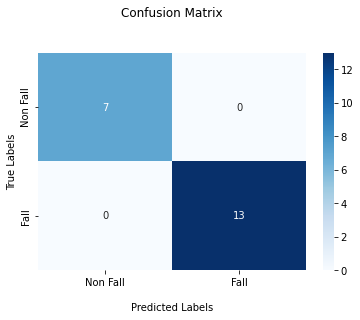

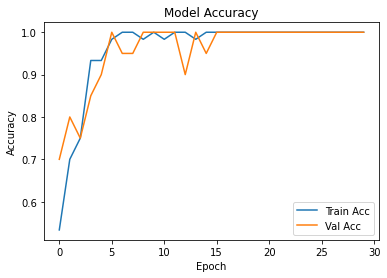

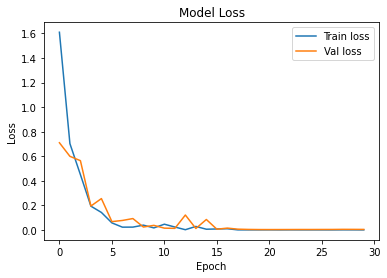

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

##### 0.0001

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
6/6 [==============================] - 4s 151ms/step - loss: 0.8006 - accuracy: 0.5667 - val_loss: 0.4226 - val_accuracy: 0.7500
Epoch 2/30
6/6 [==============================] - 0s 19ms/step - loss: 0.5820 - accuracy: 0.7333 - val_loss: 0.3895 - val_accuracy: 0.8000
Epoch 3/30
6/6 [==============================] - 0s 19ms/step - loss: 0.3927 - accuracy: 0.8500 - val_loss: 0.2309 - val_accuracy: 0.9000
Epoch 4/30
6/6 [==============================] - 0s 18ms/step - loss: 0.3259 - accuracy: 0.8667 - val_loss: 0.1557 - val_accuracy: 1.0000
Epoch 5/30
6/6 [==============================] - 0s 17ms/step - loss: 0.2132 - accuracy: 0.9333 - val_loss: 0.1333 - val_accuracy: 1.0000
Epoch 6/30
6/6 [==============================] - 0s 16ms/step - loss: 0.1787 - accuracy: 0.9500 - val_loss: 0.1218 - val_accuracy: 0.9500
Epoch 7/30
6/6 [==============================] - 0s 17ms/step - loss: 0.1228 - accuracy: 0.9833 - val_loss: 0.1150 - val_accuracy: 0.9500
Epoch 8/30
6/6 [==========

              precision    recall  f1-score   support

    Non Fall       1.00      1.00      1.00         7
        Fall       1.00      1.00      1.00        13

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1Score:  1.0


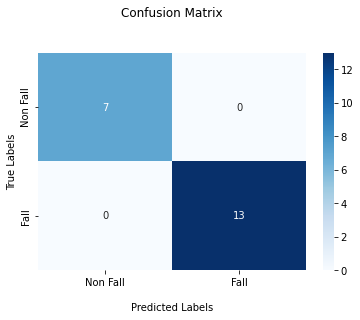

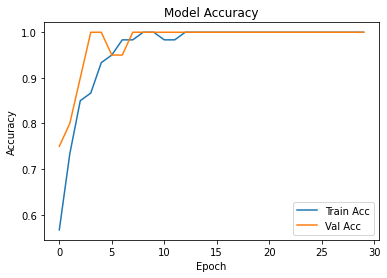

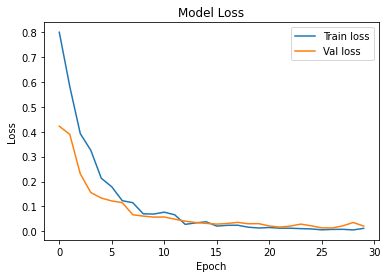

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

##### 0.00001

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.00001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
6/6 [==============================] - 8s 355ms/step - loss: 0.7605 - accuracy: 0.4833 - val_loss: 0.7496 - val_accuracy: 0.3500
Epoch 2/30
6/6 [==============================] - 0s 27ms/step - loss: 0.5940 - accuracy: 0.7000 - val_loss: 0.6730 - val_accuracy: 0.6000
Epoch 3/30
6/6 [==============================] - 0s 24ms/step - loss: 0.6734 - accuracy: 0.6500 - val_loss: 0.6251 - val_accuracy: 0.7000
Epoch 4/30
6/6 [==============================] - 0s 31ms/step - loss: 0.6520 - accuracy: 0.5833 - val_loss: 0.5797 - val_accuracy: 0.7500
Epoch 5/30
6/6 [==============================] - 0s 21ms/step - loss: 0.7288 - accuracy: 0.6500 - val_loss: 0.5610 - val_accuracy: 0.7500
Epoch 6/30
6/6 [==============================] - 0s 19ms/step - loss: 0.7288 - accuracy: 0.5167 - val_loss: 0.5198 - val_accuracy: 0.8500
Epoch 7/30
6/6 [==============================] - 0s 19ms/step - loss: 0.5401 - accuracy: 0.7333 - val_loss: 0.4907 - val_accuracy: 0.8500
Epoch 8/30
6/6 [==========

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

#### sgd

##### 0.1

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='sgd',learning_rate=0.1)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
6/6 [==============================] - 6s 231ms/step - loss: 9.3668 - accuracy: 0.4667 - val_loss: 3.6973 - val_accuracy: 0.3000
Epoch 2/30
6/6 [==============================] - 0s 21ms/step - loss: 1.4520 - accuracy: 0.5167 - val_loss: 0.6596 - val_accuracy: 0.7000
Epoch 3/30
6/6 [==============================] - 0s 21ms/step - loss: 0.7164 - accuracy: 0.5667 - val_loss: 0.5967 - val_accuracy: 0.7500
Epoch 4/30
6/6 [==============================] - 0s 17ms/step - loss: 0.6942 - accuracy: 0.6333 - val_loss: 0.7340 - val_accuracy: 0.3000
Epoch 5/30
6/6 [==============================] - 0s 19ms/step - loss: 0.8858 - accuracy: 0.4833 - val_loss: 0.5715 - val_accuracy: 0.7000
Epoch 6/30
6/6 [==============================] - 0s 17ms/step - loss: 0.6826 - accuracy: 0.5833 - val_loss: 0.6955 - val_accuracy: 0.3500
Epoch 7/30
6/6 [==============================] - 0s 19ms/step - loss: 0.6628 - accuracy: 0.7000 - val_loss: 1.5872 - val_accuracy: 0.3000
Epoch 8/30
6/6 [==========

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred)
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred)
plot_history(history)

##### 0.01

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='sgd',learning_rate=0.01)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
6/6 [==============================] - 6s 229ms/step - loss: 0.7545 - accuracy: 0.5667 - val_loss: 0.5136 - val_accuracy: 0.8000
Epoch 2/30
6/6 [==============================] - 0s 20ms/step - loss: 0.4668 - accuracy: 0.8333 - val_loss: 0.3103 - val_accuracy: 0.9000
Epoch 3/30
6/6 [==============================] - 0s 20ms/step - loss: 0.4051 - accuracy: 0.8500 - val_loss: 0.2529 - val_accuracy: 0.9500
Epoch 4/30
6/6 [==============================] - 0s 19ms/step - loss: 0.4792 - accuracy: 0.7333 - val_loss: 0.4142 - val_accuracy: 0.7500
Epoch 5/30
6/6 [==============================] - 0s 20ms/step - loss: 0.3213 - accuracy: 0.8667 - val_loss: 0.2308 - val_accuracy: 0.9000
Epoch 6/30
6/6 [==============================] - 0s 18ms/step - loss: 0.2343 - accuracy: 0.9333 - val_loss: 0.1979 - val_accuracy: 0.9000
Epoch 7/30
6/6 [==============================] - 0s 20ms/step - loss: 0.2228 - accuracy: 0.9000 - val_loss: 0.1463 - val_accuracy: 0.9500
Epoch 8/30
6/6 [==========

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

##### 0.001

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='sgd',learning_rate=0.001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
6/6 [==============================] - 7s 286ms/step - loss: 0.7568 - accuracy: 0.4333 - val_loss: 0.7871 - val_accuracy: 0.3000
Epoch 2/30
6/6 [==============================] - 0s 20ms/step - loss: 0.7379 - accuracy: 0.5000 - val_loss: 0.7116 - val_accuracy: 0.5000
Epoch 3/30
6/6 [==============================] - 0s 19ms/step - loss: 0.6881 - accuracy: 0.5500 - val_loss: 0.6783 - val_accuracy: 0.6000
Epoch 4/30
6/6 [==============================] - 0s 19ms/step - loss: 0.7184 - accuracy: 0.5167 - val_loss: 0.6440 - val_accuracy: 0.6500
Epoch 5/30
6/6 [==============================] - 0s 18ms/step - loss: 0.6842 - accuracy: 0.5167 - val_loss: 0.6049 - val_accuracy: 0.7000
Epoch 6/30
6/6 [==============================] - 0s 18ms/step - loss: 0.6028 - accuracy: 0.6333 - val_loss: 0.5756 - val_accuracy: 0.7000
Epoch 7/30
6/6 [==============================] - 0s 17ms/step - loss: 0.6267 - accuracy: 0.6500 - val_loss: 0.5546 - val_accuracy: 0.7500
Epoch 8/30
6/6 [==========

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

##### 0.0001

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='sgd',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
6/6 [==============================] - 6s 249ms/step - loss: 0.8593 - accuracy: 0.4833 - val_loss: 1.0012 - val_accuracy: 0.2500
Epoch 2/30
6/6 [==============================] - 0s 29ms/step - loss: 0.8737 - accuracy: 0.5167 - val_loss: 0.9767 - val_accuracy: 0.2500
Epoch 3/30
6/6 [==============================] - 0s 23ms/step - loss: 0.9065 - accuracy: 0.3500 - val_loss: 0.9611 - val_accuracy: 0.2500
Epoch 4/30
6/6 [==============================] - 0s 32ms/step - loss: 0.7547 - accuracy: 0.5667 - val_loss: 0.9500 - val_accuracy: 0.2500
Epoch 5/30
6/6 [==============================] - 0s 22ms/step - loss: 0.8306 - accuracy: 0.5000 - val_loss: 0.9336 - val_accuracy: 0.2000
Epoch 6/30
6/6 [==============================] - 0s 23ms/step - loss: 0.8216 - accuracy: 0.4833 - val_loss: 0.9224 - val_accuracy: 0.2000
Epoch 7/30
6/6 [==============================] - 0s 19ms/step - loss: 0.7601 - accuracy: 0.5333 - val_loss: 0.9121 - val_accuracy: 0.2000
Epoch 8/30
6/6 [==========

              precision    recall  f1-score   support

    Non Fall       1.00      0.43      0.60         7
        Fall       0.76      1.00      0.87        13

    accuracy                           0.80        20
   macro avg       0.88      0.71      0.73        20
weighted avg       0.85      0.80      0.77        20

Accuracy:  0.8
Precision:  0.7647058823529411
Recall:  1.0
F1Score:  0.8666666666666666


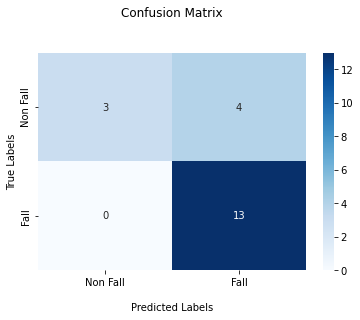

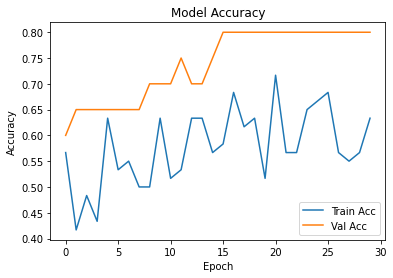

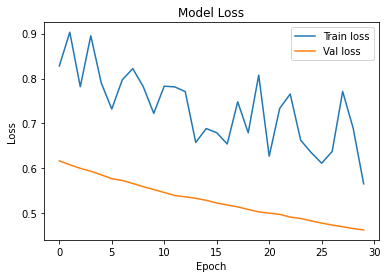

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

##### 0.00001

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='sgd',learning_rate=0.00001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
6/6 [==============================] - 6s 238ms/step - loss: 0.9288 - accuracy: 0.4667 - val_loss: 0.6749 - val_accuracy: 0.7000
Epoch 2/30
6/6 [==============================] - 0s 21ms/step - loss: 0.8174 - accuracy: 0.4500 - val_loss: 0.6738 - val_accuracy: 0.7000
Epoch 3/30
6/6 [==============================] - 0s 22ms/step - loss: 0.9627 - accuracy: 0.3000 - val_loss: 0.6724 - val_accuracy: 0.7000
Epoch 4/30
6/6 [==============================] - 0s 31ms/step - loss: 0.9022 - accuracy: 0.4333 - val_loss: 0.6716 - val_accuracy: 0.7000
Epoch 5/30
6/6 [==============================] - 0s 39ms/step - loss: 0.8366 - accuracy: 0.4833 - val_loss: 0.6704 - val_accuracy: 0.7000
Epoch 6/30
6/6 [==============================] - 0s 45ms/step - loss: 0.8504 - accuracy: 0.4667 - val_loss: 0.6694 - val_accuracy: 0.7000
Epoch 7/30
6/6 [==============================] - 0s 33ms/step - loss: 0.9872 - accuracy: 0.3667 - val_loss: 0.6691 - val_accuracy: 0.7000
Epoch 8/30
6/6 [==========

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

#### rmsprop

##### 0.1

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='rmsprop',learning_rate=0.1)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
6/6 [==============================] - 5s 209ms/step - loss: 4.1379 - accuracy: 0.5000 - val_loss: 1.3057 - val_accuracy: 0.3000
Epoch 2/30
6/6 [==============================] - 0s 29ms/step - loss: 1.5567 - accuracy: 0.4667 - val_loss: 0.6291 - val_accuracy: 0.7500
Epoch 3/30
6/6 [==============================] - 0s 26ms/step - loss: 0.4648 - accuracy: 0.8333 - val_loss: 1.0274 - val_accuracy: 0.5000
Epoch 4/30
6/6 [==============================] - 0s 30ms/step - loss: 0.6038 - accuracy: 0.7333 - val_loss: 0.2368 - val_accuracy: 0.9000
Epoch 5/30
6/6 [==============================] - 0s 25ms/step - loss: 0.3622 - accuracy: 0.8333 - val_loss: 0.2148 - val_accuracy: 0.9000
Epoch 6/30
6/6 [==============================] - 0s 25ms/step - loss: 0.2631 - accuracy: 0.8667 - val_loss: 0.1134 - val_accuracy: 0.9500
Epoch 7/30
6/6 [==============================] - 0s 25ms/step - loss: 0.3496 - accuracy: 0.8667 - val_loss: 0.8438 - val_accuracy: 0.7500
Epoch 8/30
6/6 [==========

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred)
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred)
plot_history(history)

##### 0.01

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='rmsprop',learning_rate=0.01)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
6/6 [==============================] - 5s 184ms/step - loss: 3.6930 - accuracy: 0.4000 - val_loss: 0.9884 - val_accuracy: 0.7000
Epoch 2/30
6/6 [==============================] - 0s 21ms/step - loss: 1.1928 - accuracy: 0.6000 - val_loss: 0.8129 - val_accuracy: 0.7000
Epoch 3/30
6/6 [==============================] - 0s 23ms/step - loss: 1.5135 - accuracy: 0.4500 - val_loss: 0.8911 - val_accuracy: 0.7000
Epoch 4/30
6/6 [==============================] - 0s 22ms/step - loss: 0.7317 - accuracy: 0.6833 - val_loss: 0.2531 - val_accuracy: 0.8500
Epoch 5/30
6/6 [==============================] - 0s 19ms/step - loss: 0.6908 - accuracy: 0.7000 - val_loss: 0.1956 - val_accuracy: 0.9500
Epoch 6/30
6/6 [==============================] - 0s 20ms/step - loss: 0.2685 - accuracy: 0.8667 - val_loss: 0.2373 - val_accuracy: 0.8500
Epoch 7/30
6/6 [==============================] - 0s 18ms/step - loss: 0.1769 - accuracy: 0.9000 - val_loss: 0.1235 - val_accuracy: 1.0000
Epoch 8/30
6/6 [==========

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

##### 0.001

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='rmsprop',learning_rate=0.001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
6/6 [==============================] - 29s 158ms/step - loss: 2.9424 - accuracy: 0.5667 - val_loss: 2.2016 - val_accuracy: 0.7000
Epoch 2/30
6/6 [==============================] - 0s 22ms/step - loss: 1.1952 - accuracy: 0.6333 - val_loss: 1.0697 - val_accuracy: 0.6500
Epoch 3/30
6/6 [==============================] - 0s 21ms/step - loss: 0.5395 - accuracy: 0.7833 - val_loss: 1.8677 - val_accuracy: 0.7000
Epoch 4/30
6/6 [==============================] - 0s 21ms/step - loss: 1.0768 - accuracy: 0.7167 - val_loss: 0.7257 - val_accuracy: 0.7500
Epoch 5/30
6/6 [==============================] - 0s 19ms/step - loss: 0.4922 - accuracy: 0.7833 - val_loss: 0.2615 - val_accuracy: 0.9000
Epoch 6/30
6/6 [==============================] - 0s 21ms/step - loss: 0.1324 - accuracy: 0.9333 - val_loss: 0.0899 - val_accuracy: 0.9500
Epoch 7/30
6/6 [==============================] - 0s 20ms/step - loss: 0.3825 - accuracy: 0.8333 - val_loss: 0.3052 - val_accuracy: 0.8500
Epoch 8/30
6/6 [=========

              precision    recall  f1-score   support

    Non Fall       1.00      0.86      0.92         7
        Fall       0.93      1.00      0.96        13

    accuracy                           0.95        20
   macro avg       0.96      0.93      0.94        20
weighted avg       0.95      0.95      0.95        20

Accuracy:  0.95
Precision:  0.9285714285714286
Recall:  1.0
F1Score:  0.962962962962963


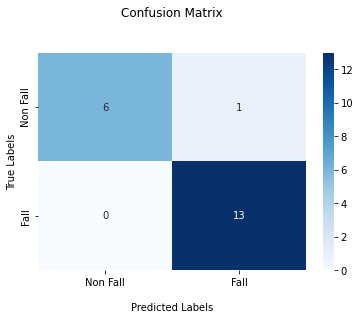

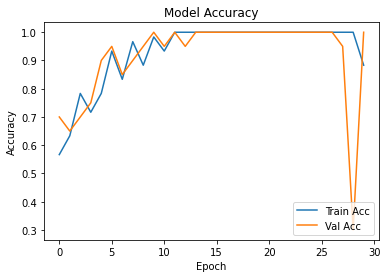

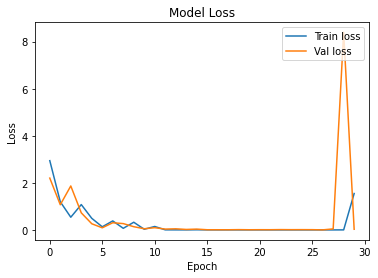

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

##### 0.0001

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='rmsprop',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
6/6 [==============================] - 4s 164ms/step - loss: 3.5683 - accuracy: 0.4667 - val_loss: 3.0572 - val_accuracy: 0.3000
Epoch 2/30
6/6 [==============================] - 0s 22ms/step - loss: 1.1251 - accuracy: 0.6667 - val_loss: 0.3975 - val_accuracy: 0.7500
Epoch 3/30
6/6 [==============================] - 0s 22ms/step - loss: 0.5622 - accuracy: 0.7667 - val_loss: 0.2817 - val_accuracy: 0.8500
Epoch 4/30
6/6 [==============================] - 0s 20ms/step - loss: 0.8036 - accuracy: 0.6833 - val_loss: 0.3431 - val_accuracy: 0.7500
Epoch 5/30
6/6 [==============================] - 0s 19ms/step - loss: 0.7319 - accuracy: 0.7500 - val_loss: 0.2213 - val_accuracy: 0.8500
Epoch 6/30
6/6 [==============================] - 0s 19ms/step - loss: 0.2485 - accuracy: 0.8833 - val_loss: 0.1253 - val_accuracy: 0.9500
Epoch 7/30
6/6 [==============================] - 0s 19ms/step - loss: 0.3410 - accuracy: 0.8500 - val_loss: 1.0539 - val_accuracy: 0.7000
Epoch 8/30
6/6 [==========

              precision    recall  f1-score   support

    Non Fall       1.00      1.00      1.00         7
        Fall       1.00      1.00      1.00        13

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1Score:  1.0


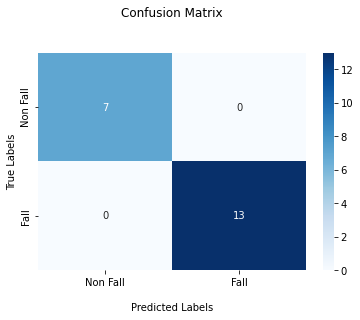

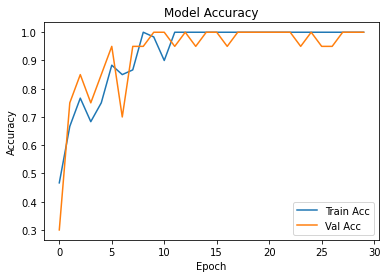

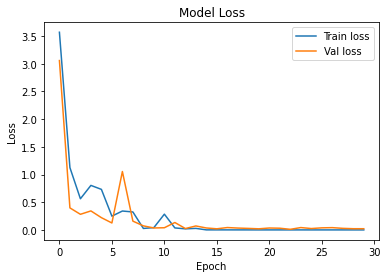

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

##### 0.00001

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='rmsprop',learning_rate=0.00001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
6/6 [==============================] - 4s 170ms/step - loss: 4.1887 - accuracy: 0.4500 - val_loss: 2.1523 - val_accuracy: 0.3000
Epoch 2/30
6/6 [==============================] - 0s 22ms/step - loss: 1.1721 - accuracy: 0.6167 - val_loss: 0.4197 - val_accuracy: 0.8000
Epoch 3/30
6/6 [==============================] - 0s 21ms/step - loss: 0.8617 - accuracy: 0.6667 - val_loss: 0.2978 - val_accuracy: 0.9000
Epoch 4/30
6/6 [==============================] - 0s 19ms/step - loss: 0.4449 - accuracy: 0.8333 - val_loss: 0.7376 - val_accuracy: 0.6000
Epoch 5/30
6/6 [==============================] - 0s 20ms/step - loss: 0.3984 - accuracy: 0.8667 - val_loss: 0.3570 - val_accuracy: 0.9000
Epoch 6/30
6/6 [==============================] - 0s 18ms/step - loss: 0.5820 - accuracy: 0.8000 - val_loss: 0.5519 - val_accuracy: 0.7500
Epoch 7/30
6/6 [==============================] - 0s 19ms/step - loss: 0.1195 - accuracy: 0.9500 - val_loss: 0.4356 - val_accuracy: 0.9000
Epoch 8/30
6/6 [==========

              precision    recall  f1-score   support

    Non Fall       1.00      1.00      1.00         7
        Fall       1.00      1.00      1.00        13

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1Score:  1.0


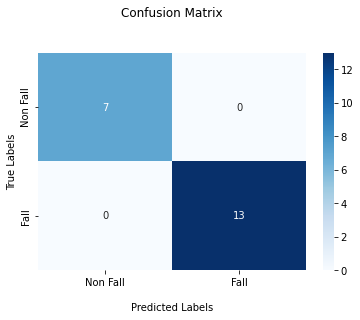

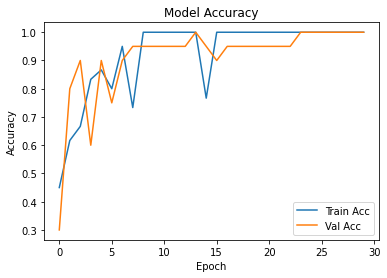

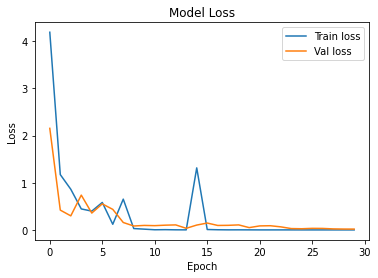

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

### Batch size

In [ ]:
data,label = load_data('urfd')
x,y = extract_features_process_label(data,label,dataset_name='urfd',model='VGG16',classification='categorical')
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(x,y,train_size=0.6)
#model.summary()

#### 10

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
6/6 [==============================] - 8s 612ms/step - loss: 0.8091 - accuracy: 0.5667 - val_loss: 0.3923 - val_accuracy: 0.9500
Epoch 2/30
6/6 [==============================] - 3s 516ms/step - loss: 0.4769 - accuracy: 0.7333 - val_loss: 0.3724 - val_accuracy: 0.9000
Epoch 3/30
6/6 [==============================] - 2s 329ms/step - loss: 0.3469 - accuracy: 0.9333 - val_loss: 0.2162 - val_accuracy: 0.9500
Epoch 4/30
6/6 [==============================] - 2s 334ms/step - loss: 0.4096 - accuracy: 0.8000 - val_loss: 0.1696 - val_accuracy: 1.0000
Epoch 5/30
6/6 [==============================] - 2s 332ms/step - loss: 0.2371 - accuracy: 0.9167 - val_loss: 0.2374 - val_accuracy: 0.9000
Epoch 6/30
6/6 [==============================] - 2s 388ms/step - loss: 0.1511 - accuracy: 0.9833 - val_loss: 0.1165 - val_accuracy: 0.9500
Epoch 7/30
6/6 [==============================] - 3s 530ms/step - loss: 0.1190 - accuracy: 0.9833 - val_loss: 0.0943 - val_accuracy: 1.0000
Epoch 8/30
6/6 [====

              precision    recall  f1-score   support

    Non Fall       1.00      1.00      1.00         7
        Fall       1.00      1.00      1.00        13

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1Score:  1.0


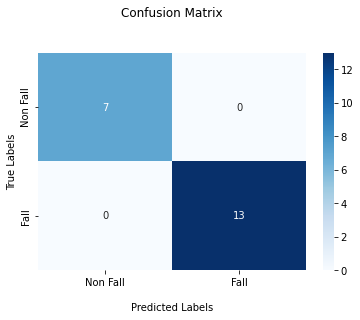

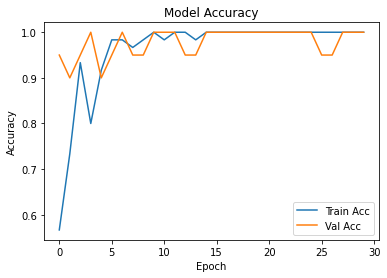

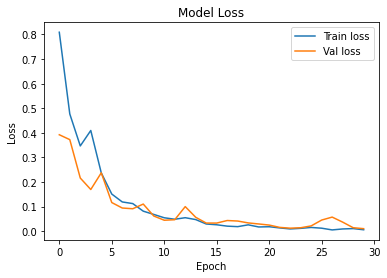

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred)
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred)
plot_history(history)

#### 16

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=16,n_epoch=30)

Epoch 1/30
4/4 [==============================] - 18s 3s/step - loss: 0.6723 - accuracy: 0.6167 - val_loss: 0.4375 - val_accuracy: 0.9000
Epoch 2/30
4/4 [==============================] - 5s 1s/step - loss: 0.5155 - accuracy: 0.7667 - val_loss: 0.2901 - val_accuracy: 0.9500
Epoch 3/30
4/4 [==============================] - 3s 904ms/step - loss: 0.3275 - accuracy: 0.8833 - val_loss: 0.2090 - val_accuracy: 1.0000
Epoch 4/30
4/4 [==============================] - 3s 859ms/step - loss: 0.2593 - accuracy: 0.9167 - val_loss: 0.1711 - val_accuracy: 0.9500
Epoch 5/30
4/4 [==============================] - 3s 764ms/step - loss: 0.2244 - accuracy: 0.9333 - val_loss: 0.1378 - val_accuracy: 0.9500
Epoch 6/30
4/4 [==============================] - 2s 623ms/step - loss: 0.2170 - accuracy: 0.9167 - val_loss: 0.0925 - val_accuracy: 1.0000
Epoch 7/30
4/4 [==============================] - 2s 613ms/step - loss: 0.1537 - accuracy: 0.9667 - val_loss: 0.0765 - val_accuracy: 1.0000
Epoch 8/30
4/4 [=========

              precision    recall  f1-score   support

    Non Fall       1.00      1.00      1.00         7
        Fall       1.00      1.00      1.00        13

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1Score:  1.0


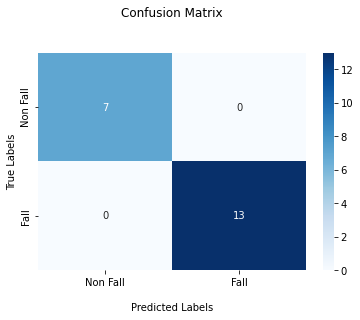

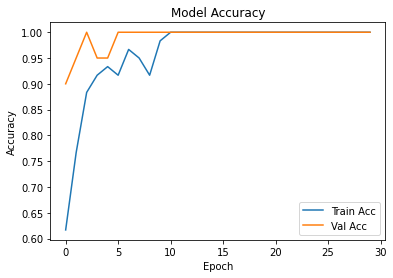

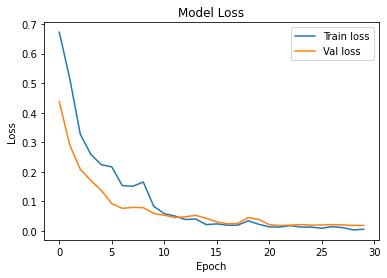

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

#### 24

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=24,n_epoch=30)

Epoch 1/30
3/3 [==============================] - 7s 860ms/step - loss: 0.8503 - accuracy: 0.4667 - val_loss: 0.6323 - val_accuracy: 0.5000
Epoch 2/30
3/3 [==============================] - 1s 433ms/step - loss: 0.5526 - accuracy: 0.6333 - val_loss: 0.3826 - val_accuracy: 0.8500
Epoch 3/30
3/3 [==============================] - 1s 434ms/step - loss: 0.5274 - accuracy: 0.7833 - val_loss: 0.3112 - val_accuracy: 0.8500
Epoch 4/30
3/3 [==============================] - 1s 431ms/step - loss: 0.4438 - accuracy: 0.7667 - val_loss: 0.2428 - val_accuracy: 1.0000
Epoch 5/30
3/3 [==============================] - 1s 439ms/step - loss: 0.2573 - accuracy: 0.9500 - val_loss: 0.2391 - val_accuracy: 0.9000
Epoch 6/30
3/3 [==============================] - 1s 434ms/step - loss: 0.2245 - accuracy: 0.9167 - val_loss: 0.2309 - val_accuracy: 0.9000
Epoch 7/30
3/3 [==============================] - 1s 439ms/step - loss: 0.2085 - accuracy: 0.9500 - val_loss: 0.1836 - val_accuracy: 0.9000
Epoch 8/30
3/3 [====

              precision    recall  f1-score   support

    Non Fall       1.00      1.00      1.00         7
        Fall       1.00      1.00      1.00        13

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1Score:  1.0


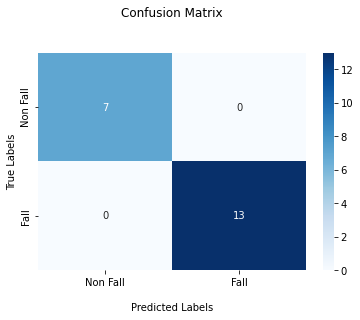

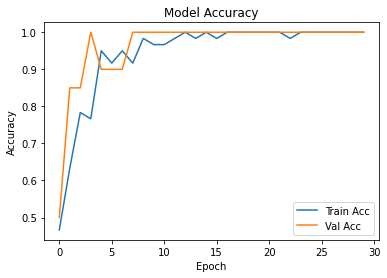

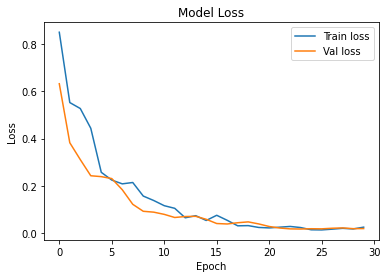

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

#### 32

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=32,n_epoch=30)

Epoch 1/30
2/2 [==============================] - 8s 1s/step - loss: 0.7181 - accuracy: 0.5500 - val_loss: 0.4801 - val_accuracy: 0.7000
Epoch 2/30
2/2 [==============================] - 1s 600ms/step - loss: 0.6251 - accuracy: 0.6000 - val_loss: 0.3797 - val_accuracy: 0.9500
Epoch 3/30
2/2 [==============================] - 1s 589ms/step - loss: 0.5270 - accuracy: 0.7333 - val_loss: 0.3157 - val_accuracy: 0.9000
Epoch 4/30
2/2 [==============================] - 1s 598ms/step - loss: 0.4041 - accuracy: 0.8500 - val_loss: 0.2520 - val_accuracy: 0.9500
Epoch 5/30
2/2 [==============================] - 1s 610ms/step - loss: 0.3498 - accuracy: 0.8667 - val_loss: 0.2122 - val_accuracy: 0.9500
Epoch 6/30
2/2 [==============================] - 2s 1s/step - loss: 0.3092 - accuracy: 0.8833 - val_loss: 0.1827 - val_accuracy: 0.9000
Epoch 7/30
2/2 [==============================] - 1s 597ms/step - loss: 0.2134 - accuracy: 0.9333 - val_loss: 0.1700 - val_accuracy: 0.9000
Epoch 8/30
2/2 [==========

              precision    recall  f1-score   support

    Non Fall       1.00      1.00      1.00         7
        Fall       1.00      1.00      1.00        13

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1Score:  1.0


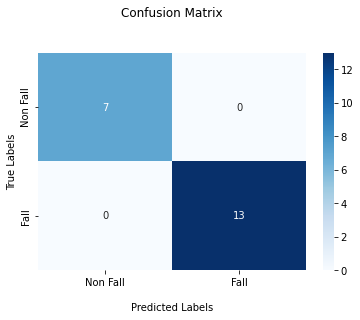

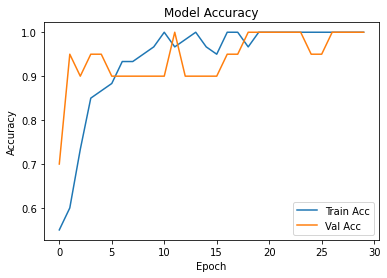

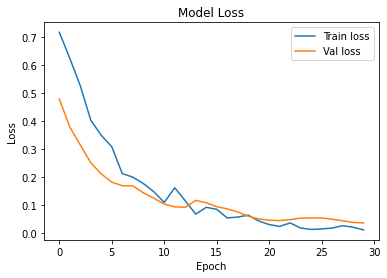

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

### VGG19 experiment for URFD

In [ ]:
data,label = load_data('urfd')
x,y = extract_features_process_label(data,label,dataset_name='urfd',model='VGG19',classification='categorical')
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(x,y,train_size=0.6)

574726144/574710816 [==============================] - 19s 0us/step


100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=16,n_epoch=50)

Epoch 1/50
4/4 [==============================] - 6s 235ms/step - loss: 0.8664 - accuracy: 0.5333 - val_loss: 0.5816 - val_accuracy: 0.6500
Epoch 2/50
4/4 [==============================] - 0s 24ms/step - loss: 0.5171 - accuracy: 0.7833 - val_loss: 0.3234 - val_accuracy: 0.8500
Epoch 3/50
4/4 [==============================] - 0s 23ms/step - loss: 0.3469 - accuracy: 0.8500 - val_loss: 0.2010 - val_accuracy: 1.0000
Epoch 4/50
4/4 [==============================] - 0s 23ms/step - loss: 0.3218 - accuracy: 0.8667 - val_loss: 0.1448 - val_accuracy: 1.0000
Epoch 5/50
4/4 [==============================] - 0s 23ms/step - loss: 0.2358 - accuracy: 0.9500 - val_loss: 0.1470 - val_accuracy: 0.9500
Epoch 6/50
4/4 [==============================] - 0s 22ms/step - loss: 0.1443 - accuracy: 0.9667 - val_loss: 0.1032 - val_accuracy: 1.0000
Epoch 7/50
4/4 [==============================] - 0s 22ms/step - loss: 0.1086 - accuracy: 0.9833 - val_loss: 0.0720 - val_accuracy: 1.0000
Epoch 8/50
4/4 [==========

              precision    recall  f1-score   support

    Non Fall       0.88      1.00      0.93         7
        Fall       1.00      0.92      0.96        13

    accuracy                           0.95        20
   macro avg       0.94      0.96      0.95        20
weighted avg       0.96      0.95      0.95        20

Accuracy:  0.95
Precision:  1.0
Recall:  0.9230769230769231
F1Score:  0.9600000000000001


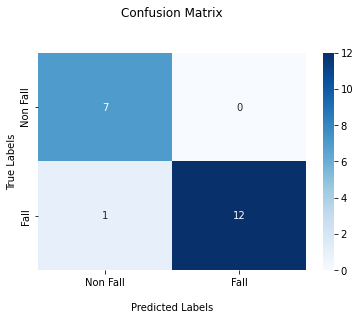

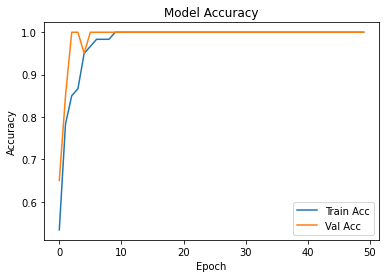

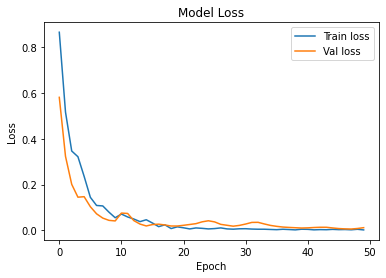

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred)
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred)
plot_history(history)

## MCFD

### Optimizer and Learning Rate

In [ ]:
data,label = load_data('mcfd')
x,y = extract_features_process_label(data,label,dataset_name='mcfd',model='VGG19',classification='categorical')
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(x,y,train_size=0.8)
#model.summary()

#### adam

##### 0.1

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.1)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
18/18 [==============================] - 14s 391ms/step - loss: 171.6522 - accuracy: 0.5057 - val_loss: 16.8336 - val_accuracy: 0.4545
Epoch 2/30
18/18 [==============================] - 6s 362ms/step - loss: 6.4151 - accuracy: 0.5057 - val_loss: 0.7002 - val_accuracy: 0.4545
Epoch 3/30
18/18 [==============================] - 9s 507ms/step - loss: 0.6972 - accuracy: 0.4659 - val_loss: 0.6956 - val_accuracy: 0.4545
Epoch 4/30
18/18 [==============================] - 8s 447ms/step - loss: 0.6941 - accuracy: 0.5341 - val_loss: 0.7155 - val_accuracy: 0.4545
Epoch 5/30
18/18 [==============================] - 8s 431ms/step - loss: 0.6938 - accuracy: 0.5341 - val_loss: 0.7010 - val_accuracy: 0.4545
Epoch 6/30
18/18 [==============================] - 8s 436ms/step - loss: 0.7153 - accuracy: 0.4375 - val_loss: 0.6942 - val_accuracy: 0.4545
Epoch 7/30
18/18 [==============================] - 6s 315ms/step - loss: 0.7119 - accuracy: 0.5341 - val_loss: 0.7106 - val_accuracy: 0.4545
Ep

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Non Fall       0.00      0.00      0.00         9
        Fall       0.61      1.00      0.76        14

    accuracy                           0.61        23
   macro avg       0.30      0.50      0.38        23
weighted avg       0.37      0.61      0.46        23

Accuracy:  0.6086956521739131
Precision:  0.6086956521739131
Recall:  1.0
F1Score:  0.7567567567567568


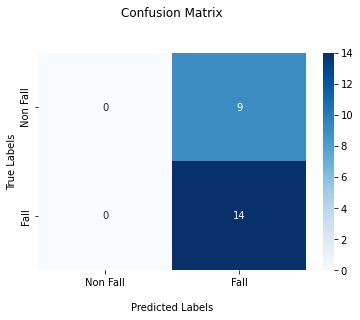

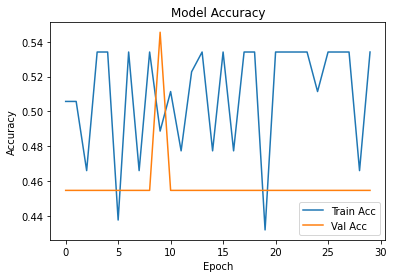

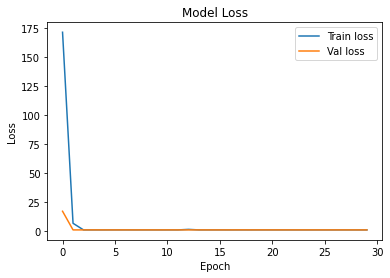

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred)
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred)
plot_history(history)

##### 0.01

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.01)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
18/18 [==============================] - 12s 384ms/step - loss: 8.1737 - accuracy: 0.5455 - val_loss: 4.7542 - val_accuracy: 0.4545
Epoch 2/30
18/18 [==============================] - 6s 332ms/step - loss: 2.0954 - accuracy: 0.5057 - val_loss: 0.6958 - val_accuracy: 0.4545
Epoch 3/30
18/18 [==============================] - 6s 331ms/step - loss: 0.8721 - accuracy: 0.4659 - val_loss: 0.6806 - val_accuracy: 0.5455
Epoch 4/30
18/18 [==============================] - 6s 329ms/step - loss: 0.7250 - accuracy: 0.4432 - val_loss: 0.6923 - val_accuracy: 0.7273
Epoch 5/30
18/18 [==============================] - 6s 331ms/step - loss: 0.6982 - accuracy: 0.4886 - val_loss: 0.6969 - val_accuracy: 0.4545
Epoch 6/30
18/18 [==============================] - 6s 334ms/step - loss: 0.6913 - accuracy: 0.5341 - val_loss: 0.6968 - val_accuracy: 0.4545
Epoch 7/30
18/18 [==============================] - 6s 333ms/step - loss: 0.6876 - accuracy: 0.5341 - val_loss: 0.7052 - val_accuracy: 0.4545
Epoch

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Non Fall       0.00      0.00      0.00         9
        Fall       0.61      1.00      0.76        14

    accuracy                           0.61        23
   macro avg       0.30      0.50      0.38        23
weighted avg       0.37      0.61      0.46        23

Accuracy:  0.6086956521739131
Precision:  0.6086956521739131
Recall:  1.0
F1Score:  0.7567567567567568


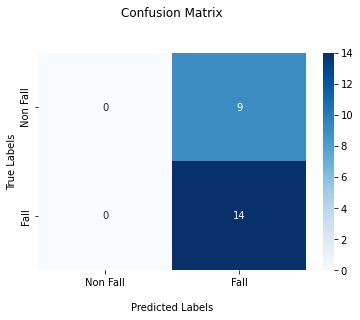

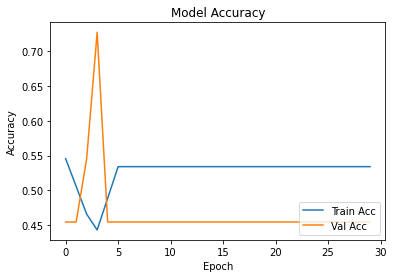

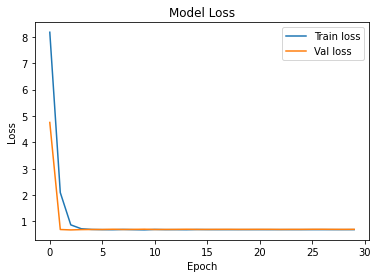

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

##### 0.001

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
18/18 [==============================] - 12s 391ms/step - loss: 1.0541 - accuracy: 0.5398 - val_loss: 0.5187 - val_accuracy: 0.7273
Epoch 2/30
18/18 [==============================] - 6s 321ms/step - loss: 0.5668 - accuracy: 0.7386 - val_loss: 0.3301 - val_accuracy: 0.8636
Epoch 3/30
18/18 [==============================] - 6s 316ms/step - loss: 0.5961 - accuracy: 0.7670 - val_loss: 0.2422 - val_accuracy: 0.8636
Epoch 4/30
18/18 [==============================] - 6s 314ms/step - loss: 0.3884 - accuracy: 0.8523 - val_loss: 0.2619 - val_accuracy: 0.9091
Epoch 5/30
18/18 [==============================] - 6s 315ms/step - loss: 0.2629 - accuracy: 0.8864 - val_loss: 0.2222 - val_accuracy: 0.8636
Epoch 6/30
18/18 [==============================] - 6s 311ms/step - loss: 0.2774 - accuracy: 0.8693 - val_loss: 0.3570 - val_accuracy: 0.8636
Epoch 7/30
18/18 [==============================] - 6s 314ms/step - loss: 0.2123 - accuracy: 0.8920 - val_loss: 0.2174 - val_accuracy: 0.8636
Epoch

              precision    recall  f1-score   support

    Non Fall       0.62      0.89      0.73         9
        Fall       0.90      0.64      0.75        14

    accuracy                           0.74        23
   macro avg       0.76      0.77      0.74        23
weighted avg       0.79      0.74      0.74        23

Accuracy:  0.7391304347826086
Precision:  0.9
Recall:  0.6428571428571429
F1Score:  0.75


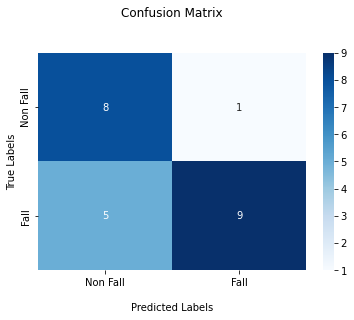

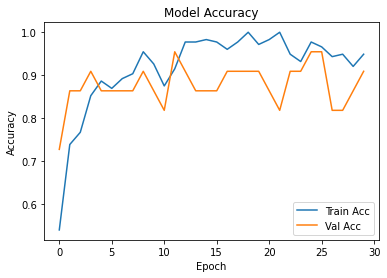

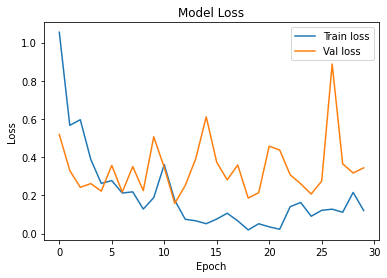

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

##### 0.0001

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
18/18 [==============================] - 11s 373ms/step - loss: 0.7508 - accuracy: 0.6080 - val_loss: 0.5236 - val_accuracy: 0.7273
Epoch 2/30
18/18 [==============================] - 6s 319ms/step - loss: 0.5280 - accuracy: 0.7216 - val_loss: 0.3990 - val_accuracy: 0.8182
Epoch 3/30
18/18 [==============================] - 6s 321ms/step - loss: 0.4456 - accuracy: 0.7955 - val_loss: 0.3397 - val_accuracy: 0.8636
Epoch 4/30
18/18 [==============================] - 6s 316ms/step - loss: 0.4014 - accuracy: 0.8352 - val_loss: 0.3047 - val_accuracy: 0.8636
Epoch 5/30
18/18 [==============================] - 6s 320ms/step - loss: 0.3063 - accuracy: 0.8636 - val_loss: 0.2863 - val_accuracy: 0.8636
Epoch 6/30
18/18 [==============================] - 7s 412ms/step - loss: 0.3195 - accuracy: 0.8636 - val_loss: 0.2313 - val_accuracy: 0.9091
Epoch 7/30
18/18 [==============================] - 6s 316ms/step - loss: 0.3200 - accuracy: 0.8523 - val_loss: 0.2576 - val_accuracy: 0.8636
Epoch

              precision    recall  f1-score   support

    Non Fall       0.73      0.89      0.80         9
        Fall       0.92      0.79      0.85        14

    accuracy                           0.83        23
   macro avg       0.82      0.84      0.82        23
weighted avg       0.84      0.83      0.83        23

Accuracy:  0.8260869565217391
Precision:  0.9166666666666666
Recall:  0.7857142857142857
F1Score:  0.8461538461538461


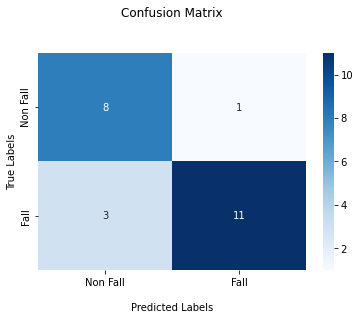

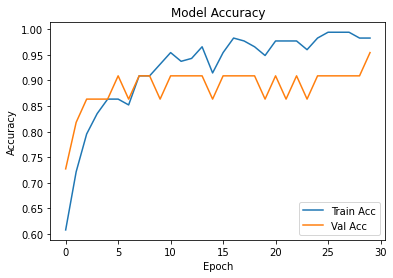

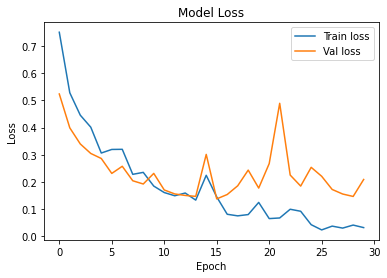

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

##### 0.00001

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.00001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
18/18 [==============================] - 14s 485ms/step - loss: 0.7857 - accuracy: 0.5455 - val_loss: 0.6553 - val_accuracy: 0.6364
Epoch 2/30
18/18 [==============================] - 6s 339ms/step - loss: 0.7511 - accuracy: 0.5227 - val_loss: 0.6336 - val_accuracy: 0.7273
Epoch 3/30
18/18 [==============================] - 6s 341ms/step - loss: 0.7228 - accuracy: 0.5739 - val_loss: 0.5854 - val_accuracy: 0.7727
Epoch 4/30
18/18 [==============================] - 6s 341ms/step - loss: 0.6996 - accuracy: 0.5739 - val_loss: 0.5402 - val_accuracy: 0.7273
Epoch 5/30
18/18 [==============================] - 6s 342ms/step - loss: 0.6696 - accuracy: 0.6307 - val_loss: 0.5277 - val_accuracy: 0.7273
Epoch 6/30
18/18 [==============================] - 6s 341ms/step - loss: 0.5883 - accuracy: 0.6875 - val_loss: 0.5119 - val_accuracy: 0.7273
Epoch 7/30
18/18 [==============================] - 6s 336ms/step - loss: 0.6403 - accuracy: 0.6477 - val_loss: 0.4747 - val_accuracy: 0.8636
Epoch

              precision    recall  f1-score   support

    Non Fall       0.78      0.78      0.78         9
        Fall       0.86      0.86      0.86        14

    accuracy                           0.83        23
   macro avg       0.82      0.82      0.82        23
weighted avg       0.83      0.83      0.83        23

Accuracy:  0.8260869565217391
Precision:  0.8571428571428571
Recall:  0.8571428571428571
F1Score:  0.8571428571428571


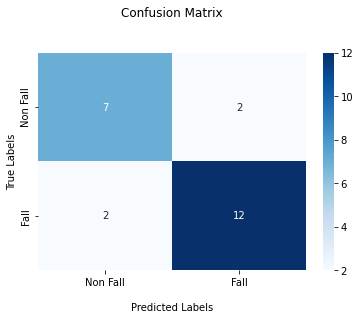

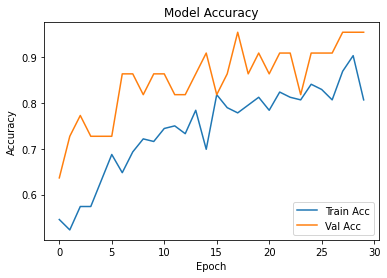

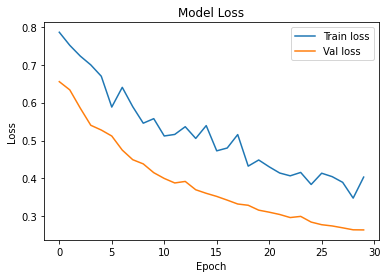

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

#### sgd

##### 0.1

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='sgd',learning_rate=0.1)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
18/18 [==============================] - 12s 372ms/step - loss: 2.7444 - accuracy: 0.5341 - val_loss: 0.8461 - val_accuracy: 0.5455
Epoch 2/30
18/18 [==============================] - 6s 322ms/step - loss: 0.7780 - accuracy: 0.4773 - val_loss: 0.6834 - val_accuracy: 0.5455
Epoch 3/30
18/18 [==============================] - 6s 319ms/step - loss: 0.7089 - accuracy: 0.5682 - val_loss: 0.7484 - val_accuracy: 0.4545
Epoch 4/30
18/18 [==============================] - 6s 316ms/step - loss: 0.6924 - accuracy: 0.5398 - val_loss: 0.6721 - val_accuracy: 0.4545
Epoch 5/30
18/18 [==============================] - 6s 322ms/step - loss: 0.7196 - accuracy: 0.5511 - val_loss: 0.5565 - val_accuracy: 0.8636
Epoch 6/30
18/18 [==============================] - 6s 314ms/step - loss: 0.7392 - accuracy: 0.6534 - val_loss: 3.0533 - val_accuracy: 0.5455
Epoch 7/30
18/18 [==============================] - 6s 316ms/step - loss: 0.8959 - accuracy: 0.6761 - val_loss: 0.6950 - val_accuracy: 0.5455
Epoch

              precision    recall  f1-score   support

    Non Fall       0.78      0.78      0.78         9
        Fall       0.86      0.86      0.86        14

    accuracy                           0.83        23
   macro avg       0.82      0.82      0.82        23
weighted avg       0.83      0.83      0.83        23

Accuracy:  0.8260869565217391
Precision:  0.8571428571428571
Recall:  0.8571428571428571
F1Score:  0.8571428571428571


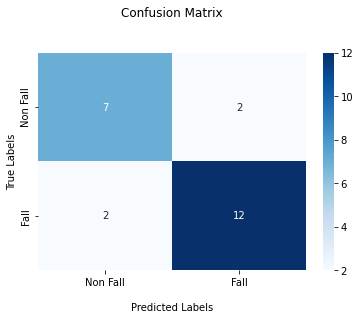

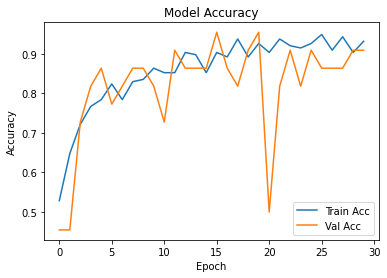

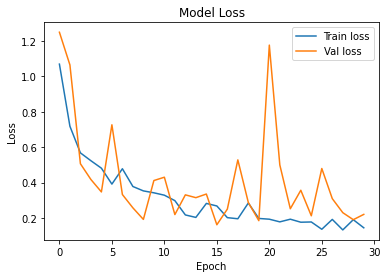

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred)
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred)
plot_history(history)

##### 0.01

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='sgd',learning_rate=0.01)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
18/18 [==============================] - 12s 364ms/step - loss: 0.8273 - accuracy: 0.5057 - val_loss: 0.8763 - val_accuracy: 0.4545
Epoch 2/30
18/18 [==============================] - 6s 312ms/step - loss: 0.6816 - accuracy: 0.6136 - val_loss: 0.4933 - val_accuracy: 0.7727
Epoch 3/30
18/18 [==============================] - 6s 310ms/step - loss: 0.5953 - accuracy: 0.7045 - val_loss: 0.7527 - val_accuracy: 0.5909
Epoch 4/30
18/18 [==============================] - 5s 301ms/step - loss: 0.6327 - accuracy: 0.6932 - val_loss: 0.4191 - val_accuracy: 0.8636
Epoch 5/30
18/18 [==============================] - 5s 302ms/step - loss: 0.4225 - accuracy: 0.8239 - val_loss: 0.8388 - val_accuracy: 0.6364
Epoch 6/30
18/18 [==============================] - 5s 304ms/step - loss: 0.3994 - accuracy: 0.8125 - val_loss: 0.3651 - val_accuracy: 0.8182
Epoch 7/30
18/18 [==============================] - 7s 410ms/step - loss: 0.4228 - accuracy: 0.8580 - val_loss: 0.3499 - val_accuracy: 0.8182
Epoch

              precision    recall  f1-score   support

    Non Fall       1.00      0.78      0.88         9
        Fall       0.88      1.00      0.93        14

    accuracy                           0.91        23
   macro avg       0.94      0.89      0.90        23
weighted avg       0.92      0.91      0.91        23

Accuracy:  0.9130434782608695
Precision:  0.875
Recall:  1.0
F1Score:  0.9333333333333333


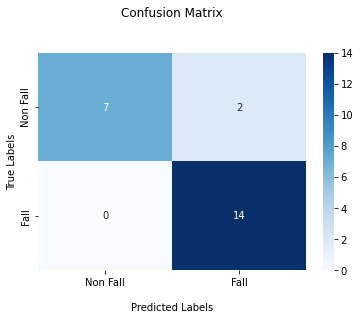

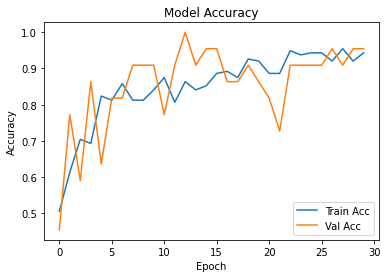

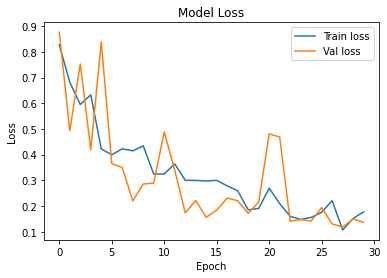

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

##### 0.001

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='sgd',learning_rate=0.001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
18/18 [==============================] - 12s 369ms/step - loss: 0.7599 - accuracy: 0.5455 - val_loss: 0.6516 - val_accuracy: 0.6364
Epoch 2/30
18/18 [==============================] - 6s 314ms/step - loss: 0.8009 - accuracy: 0.4602 - val_loss: 0.6071 - val_accuracy: 0.6364
Epoch 3/30
18/18 [==============================] - 7s 386ms/step - loss: 0.7172 - accuracy: 0.5625 - val_loss: 0.5946 - val_accuracy: 0.6818
Epoch 4/30
18/18 [==============================] - 6s 327ms/step - loss: 0.7057 - accuracy: 0.5909 - val_loss: 0.5447 - val_accuracy: 0.6818
Epoch 5/30
18/18 [==============================] - 6s 310ms/step - loss: 0.6979 - accuracy: 0.5739 - val_loss: 0.5274 - val_accuracy: 0.7727
Epoch 6/30
18/18 [==============================] - 6s 310ms/step - loss: 0.6405 - accuracy: 0.6648 - val_loss: 0.4936 - val_accuracy: 0.8182
Epoch 7/30
18/18 [==============================] - 6s 314ms/step - loss: 0.6321 - accuracy: 0.6477 - val_loss: 0.5009 - val_accuracy: 0.7273
Epoch

              precision    recall  f1-score   support

    Non Fall       0.64      0.78      0.70         9
        Fall       0.83      0.71      0.77        14

    accuracy                           0.74        23
   macro avg       0.73      0.75      0.73        23
weighted avg       0.76      0.74      0.74        23

Accuracy:  0.7391304347826086
Precision:  0.8333333333333334
Recall:  0.7142857142857143
F1Score:  0.7692307692307692


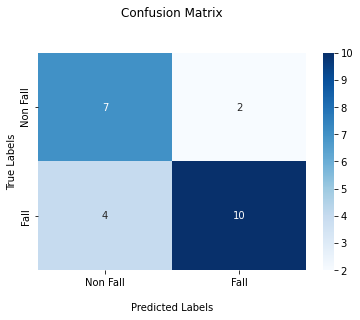

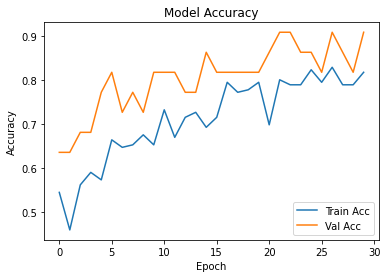

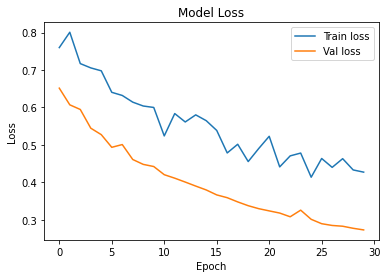

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

##### 0.0001

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='sgd',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
18/18 [==============================] - 11s 362ms/step - loss: 0.8446 - accuracy: 0.5057 - val_loss: 0.8044 - val_accuracy: 0.4545
Epoch 2/30
18/18 [==============================] - 6s 311ms/step - loss: 0.7927 - accuracy: 0.5170 - val_loss: 0.7610 - val_accuracy: 0.4545
Epoch 3/30
18/18 [==============================] - 6s 313ms/step - loss: 0.7898 - accuracy: 0.5057 - val_loss: 0.7256 - val_accuracy: 0.4545
Epoch 4/30
18/18 [==============================] - 7s 403ms/step - loss: 0.8003 - accuracy: 0.5000 - val_loss: 0.7040 - val_accuracy: 0.5000
Epoch 5/30
18/18 [==============================] - 6s 311ms/step - loss: 0.7803 - accuracy: 0.5341 - val_loss: 0.6890 - val_accuracy: 0.5909
Epoch 6/30
18/18 [==============================] - 6s 313ms/step - loss: 0.7940 - accuracy: 0.4943 - val_loss: 0.6765 - val_accuracy: 0.5909
Epoch 7/30
18/18 [==============================] - 6s 316ms/step - loss: 0.7970 - accuracy: 0.4886 - val_loss: 0.6692 - val_accuracy: 0.5909
Epoch

              precision    recall  f1-score   support

    Non Fall       0.50      0.67      0.57         9
        Fall       0.73      0.57      0.64        14

    accuracy                           0.61        23
   macro avg       0.61      0.62      0.61        23
weighted avg       0.64      0.61      0.61        23

Accuracy:  0.6086956521739131
Precision:  0.7272727272727273
Recall:  0.5714285714285714
F1Score:  0.64


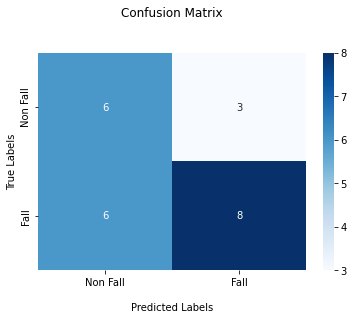

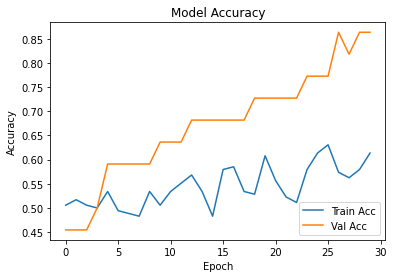

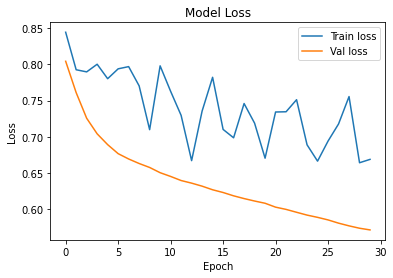

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

##### 0.00001

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='sgd',learning_rate=0.00001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
18/18 [==============================] - 11s 398ms/step - loss: 0.7461 - accuracy: 0.5455 - val_loss: 0.6112 - val_accuracy: 0.7273
Epoch 2/30
18/18 [==============================] - 6s 338ms/step - loss: 0.7636 - accuracy: 0.5455 - val_loss: 0.6109 - val_accuracy: 0.7273
Epoch 3/30
18/18 [==============================] - 6s 311ms/step - loss: 0.7310 - accuracy: 0.5284 - val_loss: 0.6105 - val_accuracy: 0.7273
Epoch 4/30
18/18 [==============================] - 6s 313ms/step - loss: 0.7522 - accuracy: 0.4773 - val_loss: 0.6103 - val_accuracy: 0.7273
Epoch 5/30
18/18 [==============================] - 7s 404ms/step - loss: 0.7554 - accuracy: 0.5114 - val_loss: 0.6099 - val_accuracy: 0.7273
Epoch 6/30
18/18 [==============================] - 6s 313ms/step - loss: 0.7730 - accuracy: 0.5341 - val_loss: 0.6097 - val_accuracy: 0.7273
Epoch 7/30
18/18 [==============================] - 6s 308ms/step - loss: 0.7829 - accuracy: 0.5114 - val_loss: 0.6094 - val_accuracy: 0.7273
Epoch

              precision    recall  f1-score   support

    Non Fall       0.38      0.56      0.45         9
        Fall       0.60      0.43      0.50        14

    accuracy                           0.48        23
   macro avg       0.49      0.49      0.48        23
weighted avg       0.52      0.48      0.48        23

Accuracy:  0.4782608695652174
Precision:  0.6
Recall:  0.42857142857142855
F1Score:  0.5


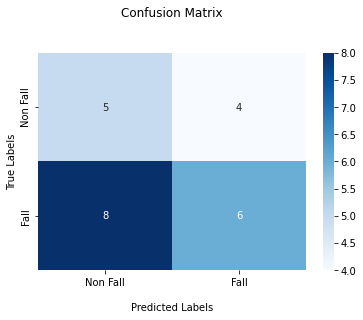

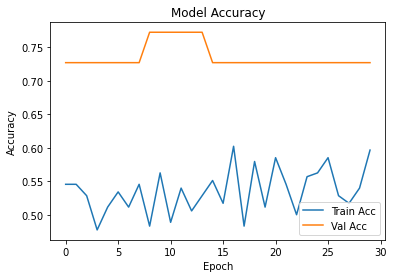

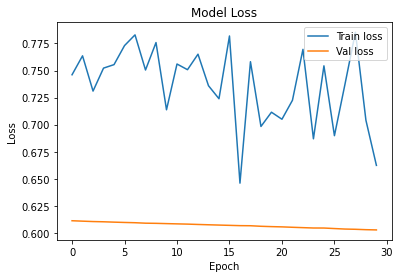

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

#### rmsprop

##### 0.1

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='rmsprop',learning_rate=0.1)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
18/18 [==============================] - 16s 636ms/step - loss: 2.1393 - accuracy: 0.5170 - val_loss: 0.6628 - val_accuracy: 0.4545
Epoch 2/30
18/18 [==============================] - 10s 549ms/step - loss: 0.9495 - accuracy: 0.5625 - val_loss: 0.4691 - val_accuracy: 0.8182
Epoch 3/30
18/18 [==============================] - 10s 566ms/step - loss: 0.8276 - accuracy: 0.6534 - val_loss: 0.5778 - val_accuracy: 0.5909
Epoch 4/30
18/18 [==============================] - 12s 665ms/step - loss: 0.6540 - accuracy: 0.7159 - val_loss: 0.5611 - val_accuracy: 0.8182
Epoch 5/30
18/18 [==============================] - 11s 589ms/step - loss: 0.5993 - accuracy: 0.8182 - val_loss: 1.1621 - val_accuracy: 0.5909
Epoch 6/30
18/18 [==============================] - 10s 569ms/step - loss: 0.5414 - accuracy: 0.7500 - val_loss: 0.3595 - val_accuracy: 0.8636
Epoch 7/30
18/18 [==============================] - 8s 468ms/step - loss: 0.3124 - accuracy: 0.8409 - val_loss: 1.2657 - val_accuracy: 0.5455


              precision    recall  f1-score   support

    Non Fall       0.88      0.78      0.82         9
        Fall       0.87      0.93      0.90        14

    accuracy                           0.87        23
   macro avg       0.87      0.85      0.86        23
weighted avg       0.87      0.87      0.87        23

Accuracy:  0.8695652173913043
Precision:  0.8666666666666667
Recall:  0.9285714285714286
F1Score:  0.896551724137931


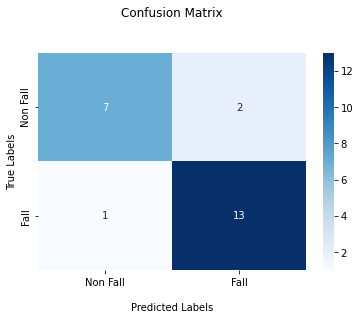

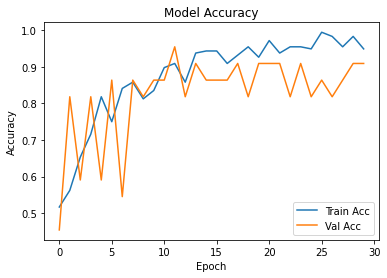

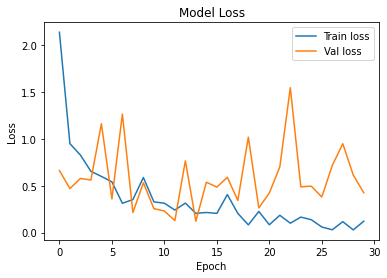

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred)
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred)
plot_history(history)

##### 0.01

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='rmsprop',learning_rate=0.01)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
18/18 [==============================] - 12s 395ms/step - loss: 2.0223 - accuracy: 0.5455 - val_loss: 1.0803 - val_accuracy: 0.4545
Epoch 2/30
18/18 [==============================] - 6s 330ms/step - loss: 1.3039 - accuracy: 0.5114 - val_loss: 0.3510 - val_accuracy: 0.8636
Epoch 3/30
18/18 [==============================] - 6s 334ms/step - loss: 1.0342 - accuracy: 0.6136 - val_loss: 0.5168 - val_accuracy: 0.7727
Epoch 4/30
18/18 [==============================] - 6s 337ms/step - loss: 0.5883 - accuracy: 0.7557 - val_loss: 0.2687 - val_accuracy: 0.8636
Epoch 5/30
18/18 [==============================] - 7s 365ms/step - loss: 0.5613 - accuracy: 0.7614 - val_loss: 0.2446 - val_accuracy: 0.8636
Epoch 6/30
18/18 [==============================] - 6s 339ms/step - loss: 0.5891 - accuracy: 0.8182 - val_loss: 0.2583 - val_accuracy: 0.8182
Epoch 7/30
18/18 [==============================] - 6s 346ms/step - loss: 0.4673 - accuracy: 0.8295 - val_loss: 0.4364 - val_accuracy: 0.7727
Epoch

              precision    recall  f1-score   support

    Non Fall       0.89      0.89      0.89         9
        Fall       0.93      0.93      0.93        14

    accuracy                           0.91        23
   macro avg       0.91      0.91      0.91        23
weighted avg       0.91      0.91      0.91        23

Accuracy:  0.9130434782608695
Precision:  0.9285714285714286
Recall:  0.9285714285714286
F1Score:  0.9285714285714286


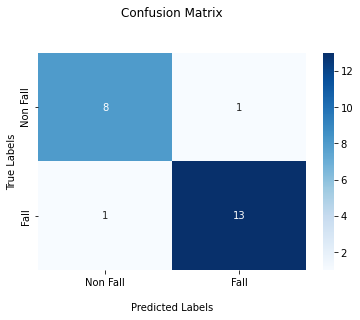

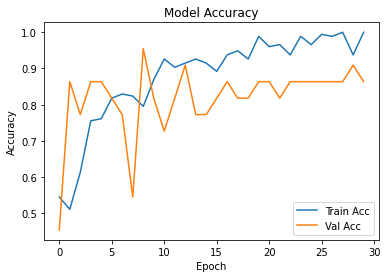

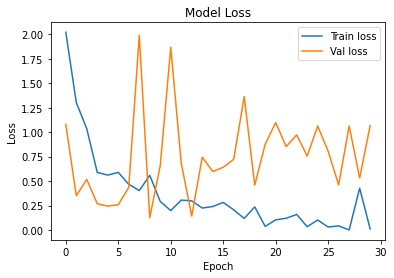

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

##### 0.001

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='rmsprop',learning_rate=0.001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
18/18 [==============================] - 12s 394ms/step - loss: 2.1773 - accuracy: 0.4943 - val_loss: 0.8858 - val_accuracy: 0.5455
Epoch 2/30
18/18 [==============================] - 6s 349ms/step - loss: 0.7738 - accuracy: 0.6534 - val_loss: 0.4977 - val_accuracy: 0.7727
Epoch 3/30
18/18 [==============================] - 6s 347ms/step - loss: 1.0563 - accuracy: 0.5455 - val_loss: 0.8981 - val_accuracy: 0.6364
Epoch 4/30
18/18 [==============================] - 6s 351ms/step - loss: 0.5839 - accuracy: 0.7443 - val_loss: 0.2941 - val_accuracy: 0.9091
Epoch 5/30
18/18 [==============================] - 6s 351ms/step - loss: 0.5478 - accuracy: 0.7784 - val_loss: 0.2341 - val_accuracy: 0.8636
Epoch 6/30
18/18 [==============================] - 8s 437ms/step - loss: 0.5386 - accuracy: 0.7898 - val_loss: 1.6586 - val_accuracy: 0.5909
Epoch 7/30
18/18 [==============================] - 7s 359ms/step - loss: 0.4999 - accuracy: 0.7955 - val_loss: 0.1689 - val_accuracy: 0.9091
Epoch

              precision    recall  f1-score   support

    Non Fall       0.78      0.78      0.78         9
        Fall       0.86      0.86      0.86        14

    accuracy                           0.83        23
   macro avg       0.82      0.82      0.82        23
weighted avg       0.83      0.83      0.83        23

Accuracy:  0.8260869565217391
Precision:  0.8571428571428571
Recall:  0.8571428571428571
F1Score:  0.8571428571428571


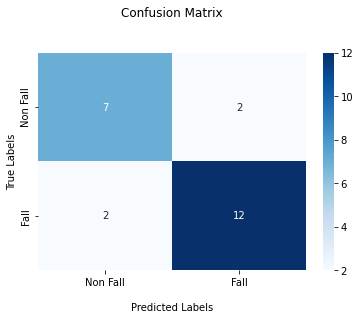

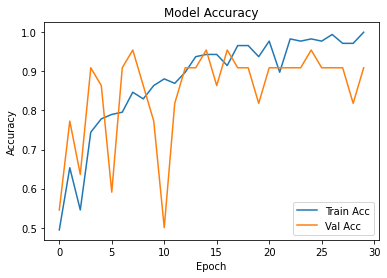

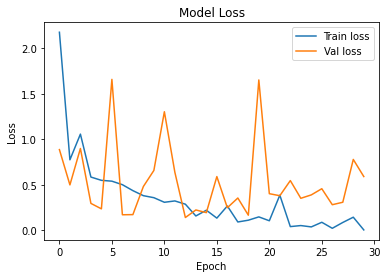

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

##### 0.0001

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='rmsprop',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
18/18 [==============================] - 12s 392ms/step - loss: 2.0686 - accuracy: 0.4773 - val_loss: 0.6197 - val_accuracy: 0.5455
Epoch 2/30
18/18 [==============================] - 6s 348ms/step - loss: 0.8172 - accuracy: 0.5795 - val_loss: 0.9460 - val_accuracy: 0.4545
Epoch 3/30
18/18 [==============================] - 6s 342ms/step - loss: 0.9800 - accuracy: 0.5852 - val_loss: 1.0089 - val_accuracy: 0.5455
Epoch 4/30
18/18 [==============================] - 8s 435ms/step - loss: 0.6051 - accuracy: 0.7330 - val_loss: 0.4440 - val_accuracy: 0.8182
Epoch 5/30
18/18 [==============================] - 6s 346ms/step - loss: 0.6612 - accuracy: 0.7727 - val_loss: 0.8578 - val_accuracy: 0.6818
Epoch 6/30
18/18 [==============================] - 6s 347ms/step - loss: 0.4401 - accuracy: 0.8239 - val_loss: 0.3061 - val_accuracy: 0.8636
Epoch 7/30
18/18 [==============================] - 8s 447ms/step - loss: 0.5034 - accuracy: 0.8239 - val_loss: 0.1713 - val_accuracy: 0.9091
Epoch

              precision    recall  f1-score   support

    Non Fall       1.00      0.44      0.62         9
        Fall       0.74      1.00      0.85        14

    accuracy                           0.78        23
   macro avg       0.87      0.72      0.73        23
weighted avg       0.84      0.78      0.76        23

Accuracy:  0.782608695652174
Precision:  0.7368421052631579
Recall:  1.0
F1Score:  0.8484848484848484


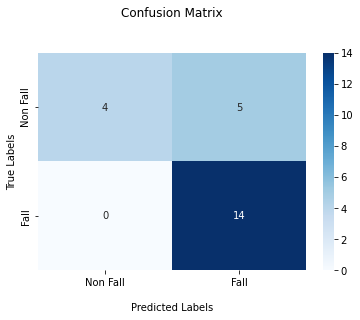

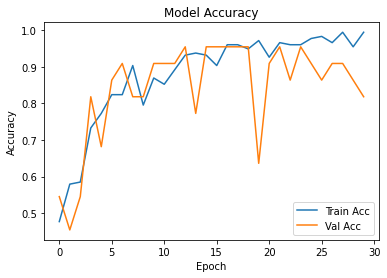

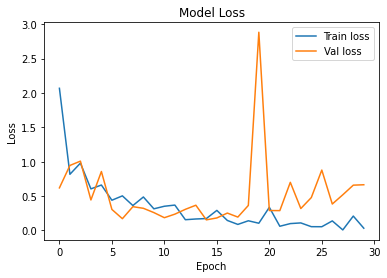

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

##### 0.00001

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='rmsprop',learning_rate=0.00001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
18/18 [==============================] - 14s 471ms/step - loss: 2.1717 - accuracy: 0.4886 - val_loss: 0.6167 - val_accuracy: 0.5455
Epoch 2/30
18/18 [==============================] - 6s 338ms/step - loss: 0.9895 - accuracy: 0.5114 - val_loss: 0.5171 - val_accuracy: 0.8636
Epoch 3/30
18/18 [==============================] - 6s 343ms/step - loss: 1.0154 - accuracy: 0.5625 - val_loss: 0.4805 - val_accuracy: 0.8182
Epoch 4/30
18/18 [==============================] - 6s 345ms/step - loss: 0.5376 - accuracy: 0.7727 - val_loss: 0.7502 - val_accuracy: 0.6364
Epoch 5/30
18/18 [==============================] - 6s 343ms/step - loss: 0.8156 - accuracy: 0.6477 - val_loss: 0.8381 - val_accuracy: 0.5000
Epoch 6/30
18/18 [==============================] - 6s 338ms/step - loss: 0.6047 - accuracy: 0.7443 - val_loss: 0.3063 - val_accuracy: 0.8636
Epoch 7/30
18/18 [==============================] - 6s 335ms/step - loss: 0.5392 - accuracy: 0.8011 - val_loss: 0.6657 - val_accuracy: 0.7727
Epoch

              precision    recall  f1-score   support

    Non Fall       1.00      0.56      0.71         9
        Fall       0.78      1.00      0.88        14

    accuracy                           0.83        23
   macro avg       0.89      0.78      0.79        23
weighted avg       0.86      0.83      0.81        23

Accuracy:  0.8260869565217391
Precision:  0.7777777777777778
Recall:  1.0
F1Score:  0.8750000000000001


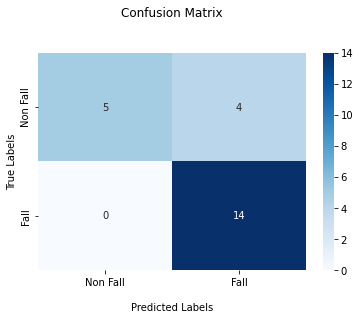

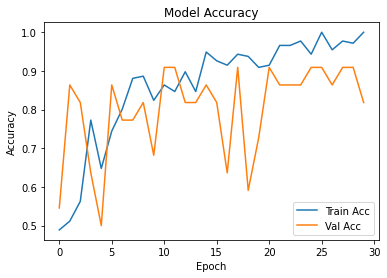

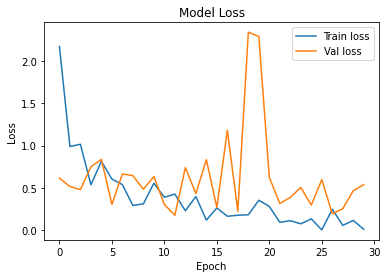

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

### Batch size

In [ ]:
data,label = load_data('mcfd')
x,y = extract_features_process_label(data,label,dataset_name='mcfd',model='VGG16',classification='categorical')
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(x,y,train_size=0.8)
#model.summary()

553476096/553467096 [==============================] - 19s 0us/step


100%|██████████| 221/221 [37:53<00:00, 10.29s/it]


#### 10

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=30)

Epoch 1/30
18/18 [==============================] - 13s 392ms/step - loss: 0.8636 - accuracy: 0.5284 - val_loss: 0.5103 - val_accuracy: 0.7727
Epoch 2/30
18/18 [==============================] - 6s 329ms/step - loss: 0.5985 - accuracy: 0.6534 - val_loss: 0.5148 - val_accuracy: 0.7727
Epoch 3/30
18/18 [==============================] - 6s 326ms/step - loss: 0.4902 - accuracy: 0.7841 - val_loss: 0.3716 - val_accuracy: 0.8182
Epoch 4/30
18/18 [==============================] - 6s 325ms/step - loss: 0.4702 - accuracy: 0.8011 - val_loss: 0.3193 - val_accuracy: 0.8636
Epoch 5/30
18/18 [==============================] - 6s 326ms/step - loss: 0.3898 - accuracy: 0.8182 - val_loss: 0.3226 - val_accuracy: 0.8182
Epoch 6/30
18/18 [==============================] - 6s 326ms/step - loss: 0.3763 - accuracy: 0.8295 - val_loss: 0.3335 - val_accuracy: 0.8182
Epoch 7/30
18/18 [==============================] - 6s 325ms/step - loss: 0.3723 - accuracy: 0.8409 - val_loss: 0.2526 - val_accuracy: 0.8636
Epoch

              precision    recall  f1-score   support

    Non Fall       0.80      0.89      0.84         9
        Fall       0.92      0.86      0.89        14

    accuracy                           0.87        23
   macro avg       0.86      0.87      0.87        23
weighted avg       0.87      0.87      0.87        23

Accuracy:  0.8695652173913043
Precision:  0.9230769230769231
Recall:  0.8571428571428571
F1Score:  0.888888888888889


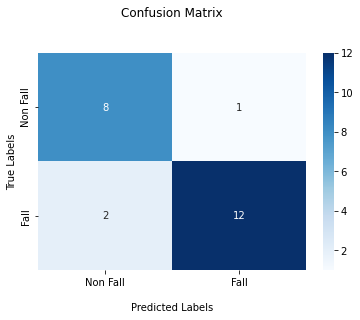

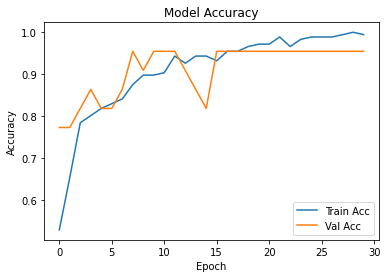

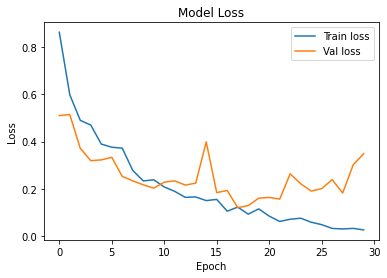

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred)
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred)
plot_history(history)

#### 16

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=16,n_epoch=30)

Epoch 1/30
11/11 [==============================] - 9s 493ms/step - loss: 0.8081 - accuracy: 0.5114 - val_loss: 0.5787 - val_accuracy: 0.7273
Epoch 2/30
11/11 [==============================] - 4s 362ms/step - loss: 0.5846 - accuracy: 0.6591 - val_loss: 0.4356 - val_accuracy: 0.8182
Epoch 3/30
11/11 [==============================] - 4s 357ms/step - loss: 0.5191 - accuracy: 0.7386 - val_loss: 0.3891 - val_accuracy: 0.7727
Epoch 4/30
11/11 [==============================] - 4s 359ms/step - loss: 0.4484 - accuracy: 0.7955 - val_loss: 0.3296 - val_accuracy: 0.8182
Epoch 5/30
11/11 [==============================] - 4s 362ms/step - loss: 0.3836 - accuracy: 0.8523 - val_loss: 0.3164 - val_accuracy: 0.8636
Epoch 6/30
11/11 [==============================] - 4s 359ms/step - loss: 0.4020 - accuracy: 0.8295 - val_loss: 0.2491 - val_accuracy: 0.9091
Epoch 7/30
11/11 [==============================] - 4s 361ms/step - loss: 0.3434 - accuracy: 0.8409 - val_loss: 0.2314 - val_accuracy: 0.9091
Epoch 

              precision    recall  f1-score   support

    Non Fall       1.00      0.78      0.88         9
        Fall       0.88      1.00      0.93        14

    accuracy                           0.91        23
   macro avg       0.94      0.89      0.90        23
weighted avg       0.92      0.91      0.91        23

Accuracy:  0.9130434782608695
Precision:  0.875
Recall:  1.0
F1Score:  0.9333333333333333


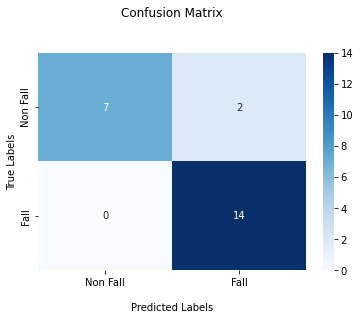

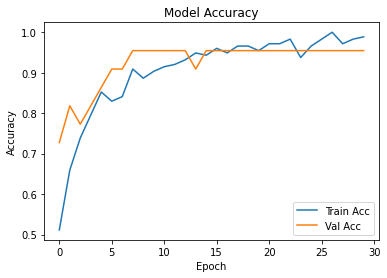

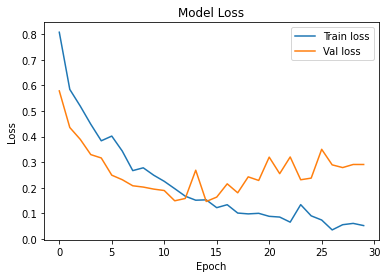

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

#### 24

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=24,n_epoch=30)

Epoch 1/30
8/8 [==============================] - 10s 532ms/step - loss: 0.7448 - accuracy: 0.5170 - val_loss: 0.5738 - val_accuracy: 0.6818
Epoch 2/30
8/8 [==============================] - 3s 412ms/step - loss: 0.6157 - accuracy: 0.6705 - val_loss: 0.5204 - val_accuracy: 0.6818
Epoch 3/30
8/8 [==============================] - 3s 403ms/step - loss: 0.5852 - accuracy: 0.6591 - val_loss: 0.4174 - val_accuracy: 0.8182
Epoch 4/30
8/8 [==============================] - 4s 463ms/step - loss: 0.5035 - accuracy: 0.7500 - val_loss: 0.3976 - val_accuracy: 0.8182
Epoch 5/30
8/8 [==============================] - 4s 500ms/step - loss: 0.3731 - accuracy: 0.8693 - val_loss: 0.3507 - val_accuracy: 0.8182
Epoch 6/30
8/8 [==============================] - 3s 400ms/step - loss: 0.4207 - accuracy: 0.7898 - val_loss: 0.3237 - val_accuracy: 0.8636
Epoch 7/30
8/8 [==============================] - 3s 405ms/step - loss: 0.3548 - accuracy: 0.8409 - val_loss: 0.2976 - val_accuracy: 0.8636
Epoch 8/30
8/8 [===

              precision    recall  f1-score   support

    Non Fall       0.88      0.78      0.82         9
        Fall       0.87      0.93      0.90        14

    accuracy                           0.87        23
   macro avg       0.87      0.85      0.86        23
weighted avg       0.87      0.87      0.87        23

Accuracy:  0.8695652173913043
Precision:  0.8666666666666667
Recall:  0.9285714285714286
F1Score:  0.896551724137931


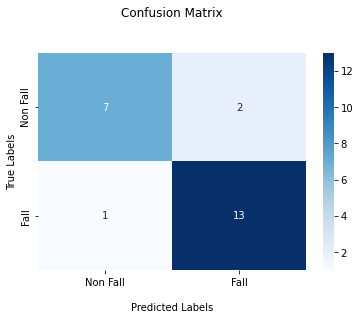

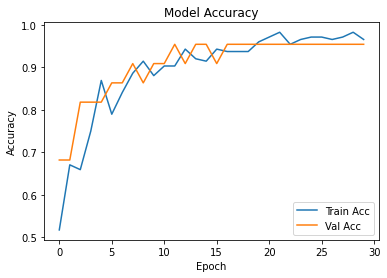

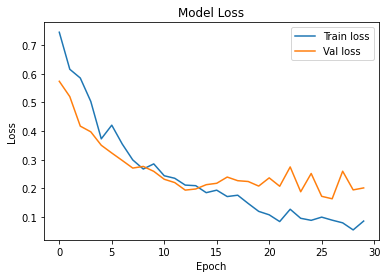

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

#### 32

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=32,n_epoch=30)

Epoch 1/30
6/6 [==============================] - 9s 684ms/step - loss: 0.7567 - accuracy: 0.4943 - val_loss: 0.5841 - val_accuracy: 0.5909
Epoch 2/30
6/6 [==============================] - 3s 512ms/step - loss: 0.6404 - accuracy: 0.6477 - val_loss: 0.4694 - val_accuracy: 0.8182
Epoch 3/30
6/6 [==============================] - 3s 520ms/step - loss: 0.5502 - accuracy: 0.7216 - val_loss: 0.4548 - val_accuracy: 0.7273
Epoch 4/30
6/6 [==============================] - 3s 510ms/step - loss: 0.4593 - accuracy: 0.7784 - val_loss: 0.3663 - val_accuracy: 0.8636
Epoch 5/30
6/6 [==============================] - 3s 514ms/step - loss: 0.4612 - accuracy: 0.7898 - val_loss: 0.3251 - val_accuracy: 0.8636
Epoch 6/30
6/6 [==============================] - 3s 513ms/step - loss: 0.3869 - accuracy: 0.8523 - val_loss: 0.3199 - val_accuracy: 0.8182
Epoch 7/30
6/6 [==============================] - 3s 511ms/step - loss: 0.3339 - accuracy: 0.8523 - val_loss: 0.2809 - val_accuracy: 0.8636
Epoch 8/30
6/6 [====

              precision    recall  f1-score   support

    Non Fall       0.88      0.78      0.82         9
        Fall       0.87      0.93      0.90        14

    accuracy                           0.87        23
   macro avg       0.87      0.85      0.86        23
weighted avg       0.87      0.87      0.87        23

Accuracy:  0.8695652173913043
Precision:  0.8666666666666667
Recall:  0.9285714285714286
F1Score:  0.896551724137931


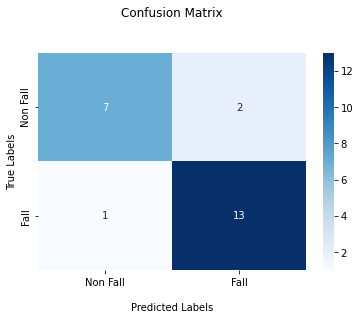

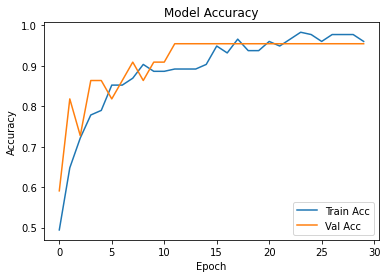

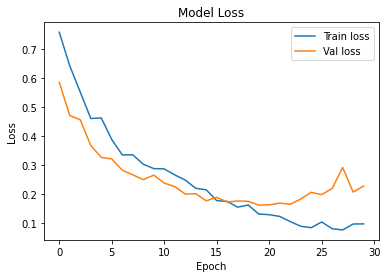

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

### mcfd more 

In [ ]:
data,label = load_data('mcfd')
x,y = extract_features_process_label(data,label,dataset_name='mcfd',model='VGG19',classification='categorical')
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(x,y,train_size=0.8)
#model.summary()
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bilstm',n_neuron=512,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.00001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=50)

Epoch 1/50
18/18 [==============================] - 14s 258ms/step - loss: 0.7021 - accuracy: 0.5455 - val_loss: 0.6855 - val_accuracy: 0.5455
Epoch 2/50
18/18 [==============================] - 3s 192ms/step - loss: 0.7011 - accuracy: 0.5341 - val_loss: 0.6149 - val_accuracy: 0.7273
Epoch 3/50
18/18 [==============================] - 3s 191ms/step - loss: 0.6445 - accuracy: 0.6307 - val_loss: 0.5713 - val_accuracy: 0.7727
Epoch 4/50
18/18 [==============================] - 3s 192ms/step - loss: 0.5752 - accuracy: 0.7330 - val_loss: 0.5317 - val_accuracy: 0.7273
Epoch 5/50
18/18 [==============================] - 5s 284ms/step - loss: 0.5720 - accuracy: 0.7045 - val_loss: 0.5031 - val_accuracy: 0.7273
Epoch 6/50
18/18 [==============================] - 4s 194ms/step - loss: 0.5257 - accuracy: 0.7216 - val_loss: 0.4790 - val_accuracy: 0.7273
Epoch 7/50
18/18 [==============================] - 3s 190ms/step - loss: 0.4944 - accuracy: 0.7898 - val_loss: 0.4569 - val_accuracy: 0.7273
Epoch

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

####agerta

              precision    recall  f1-score   support

    Non Fall       0.92      1.00      0.96        12
        Fall       1.00      0.90      0.95        10

    accuracy                           0.95        22
   macro avg       0.96      0.95      0.95        22
weighted avg       0.96      0.95      0.95        22

Accuracy:  0.9545454545454546
Precision:  1.0
Recall:  0.9
F1Score:  0.9473684210526316


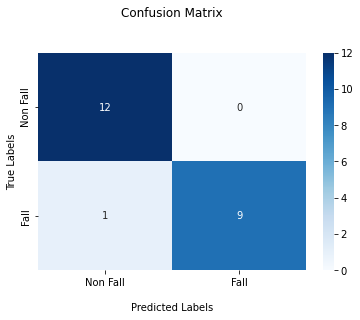

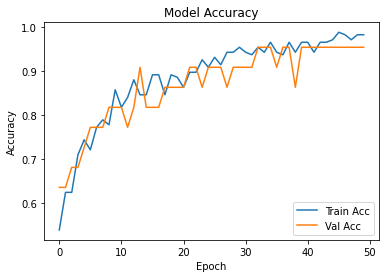

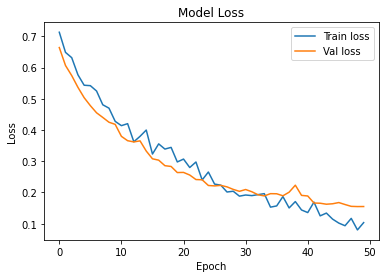

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

## MCFD RNN variants with VGG19

### bi-lstm

In [ ]:
data,label = load_data('mcfd')
x,y = extract_features_process_label(data,label,dataset_name='mcfd',model='VGG19',classification='categorical')
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(x,y,train_size=0.8)
#model.summary()

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bilstm',n_neuron=512,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.00001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=50)

Epoch 1/50
18/18 [==============================] - 45s 2s/step - loss: 0.7043 - accuracy: 0.5170 - val_loss: 0.6678 - val_accuracy: 0.5455
Epoch 2/50
18/18 [==============================] - 35s 2s/step - loss: 0.6800 - accuracy: 0.5398 - val_loss: 0.5968 - val_accuracy: 0.7273
Epoch 3/50
18/18 [==============================] - 39s 2s/step - loss: 0.6088 - accuracy: 0.6648 - val_loss: 0.5660 - val_accuracy: 0.6818
Epoch 4/50
18/18 [==============================] - 38s 2s/step - loss: 0.5838 - accuracy: 0.7216 - val_loss: 0.5367 - val_accuracy: 0.6818
Epoch 5/50
18/18 [==============================] - 36s 2s/step - loss: 0.5470 - accuracy: 0.7500 - val_loss: 0.4980 - val_accuracy: 0.6818
Epoch 6/50
18/18 [==============================] - 36s 2s/step - loss: 0.5147 - accuracy: 0.7727 - val_loss: 0.4636 - val_accuracy: 0.8182
Epoch 7/50
18/18 [==============================] - 35s 2s/step - loss: 0.5156 - accuracy: 0.7670 - val_loss: 0.4385 - val_accuracy: 0.7727
Epoch 8/50
18/18 [==

              precision    recall  f1-score   support

    Non Fall       0.78      0.78      0.78         9
        Fall       0.86      0.86      0.86        14

    accuracy                           0.83        23
   macro avg       0.82      0.82      0.82        23
weighted avg       0.83      0.83      0.83        23

Accuracy:  0.8260869565217391
Precision:  0.8571428571428571
Recall:  0.8571428571428571
F1Score:  0.8571428571428571


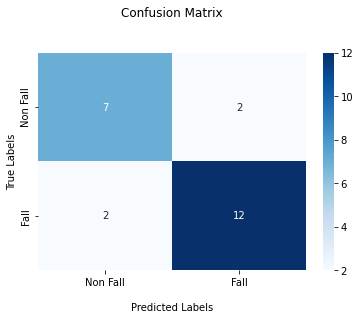

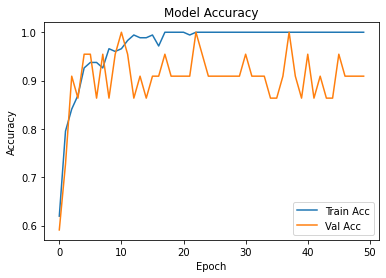

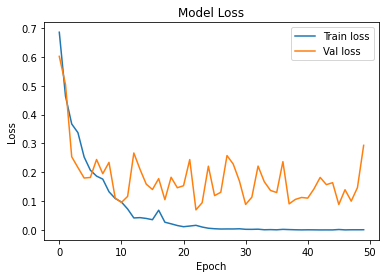

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

### LSTM

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='lstm',n_neuron=512,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=50)

Epoch 1/50
18/18 [==============================] - 4s 120ms/step - loss: 0.6118 - accuracy: 0.6705 - val_loss: 0.5075 - val_accuracy: 0.7727
Epoch 2/50
18/18 [==============================] - 2s 96ms/step - loss: 0.5072 - accuracy: 0.7614 - val_loss: 0.4187 - val_accuracy: 0.8182
Epoch 3/50
18/18 [==============================] - 2s 102ms/step - loss: 0.4348 - accuracy: 0.8068 - val_loss: 0.2640 - val_accuracy: 0.8636
Epoch 4/50
18/18 [==============================] - 2s 100ms/step - loss: 0.3571 - accuracy: 0.8523 - val_loss: 0.2468 - val_accuracy: 0.8636
Epoch 5/50
18/18 [==============================] - 2s 97ms/step - loss: 0.3411 - accuracy: 0.8466 - val_loss: 0.1953 - val_accuracy: 0.9091
Epoch 6/50
18/18 [==============================] - 2s 97ms/step - loss: 0.2718 - accuracy: 0.8864 - val_loss: 0.2736 - val_accuracy: 0.8636
Epoch 7/50
18/18 [==============================] - 2s 93ms/step - loss: 0.2291 - accuracy: 0.9091 - val_loss: 0.2226 - val_accuracy: 0.9545
Epoch 8/50

              precision    recall  f1-score   support

    Non Fall       1.00      0.67      0.80         9
        Fall       0.82      1.00      0.90        14

    accuracy                           0.87        23
   macro avg       0.91      0.83      0.85        23
weighted avg       0.89      0.87      0.86        23

Accuracy:  0.8695652173913043
Precision:  0.8235294117647058
Recall:  1.0
F1Score:  0.9032258064516129


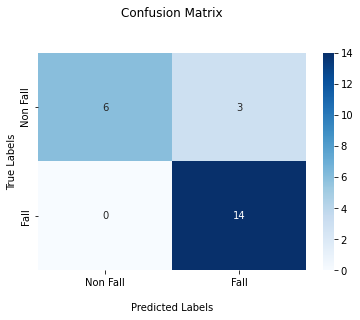

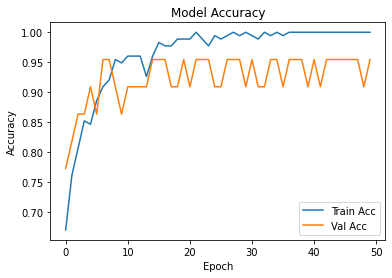

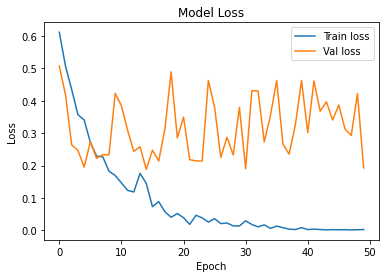

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

### GRU

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='gru',n_neuron=512,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=50)

Epoch 1/50
18/18 [==============================] - 2s 39ms/step - loss: 0.7227 - accuracy: 0.5852 - val_loss: 0.4548 - val_accuracy: 0.6818
Epoch 2/50
18/18 [==============================] - 0s 14ms/step - loss: 0.5489 - accuracy: 0.7330 - val_loss: 0.3784 - val_accuracy: 0.8182
Epoch 3/50
18/18 [==============================] - 0s 12ms/step - loss: 0.5282 - accuracy: 0.7500 - val_loss: 0.4681 - val_accuracy: 0.7727
Epoch 4/50
18/18 [==============================] - 0s 11ms/step - loss: 0.4534 - accuracy: 0.7841 - val_loss: 0.4185 - val_accuracy: 0.7727
Epoch 5/50
18/18 [==============================] - 0s 11ms/step - loss: 0.3778 - accuracy: 0.8239 - val_loss: 0.3426 - val_accuracy: 0.8636
Epoch 6/50
18/18 [==============================] - 0s 11ms/step - loss: 0.3332 - accuracy: 0.8807 - val_loss: 0.4031 - val_accuracy: 0.8182
Epoch 7/50
18/18 [==============================] - 0s 11ms/step - loss: 0.3027 - accuracy: 0.8977 - val_loss: 0.2131 - val_accuracy: 0.9091
Epoch 8/50
18

              precision    recall  f1-score   support

    Non Fall       0.86      0.67      0.75         9
        Fall       0.81      0.93      0.87        14

    accuracy                           0.83        23
   macro avg       0.83      0.80      0.81        23
weighted avg       0.83      0.83      0.82        23

Accuracy:  0.8260869565217391
Precision:  0.8125
Recall:  0.9285714285714286
F1Score:  0.8666666666666666


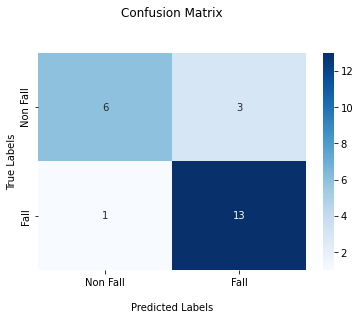

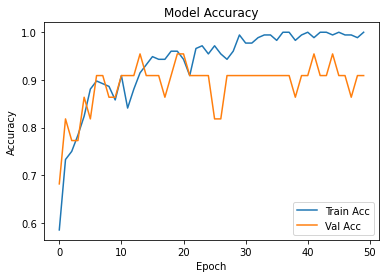

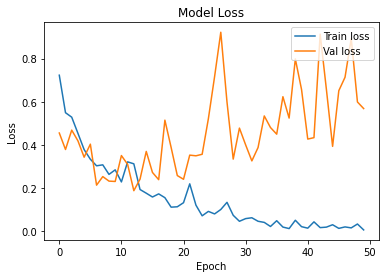

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

#### MCFD VGG16

In [ ]:
data,label = load_data('mcfd')
x,y = extract_features_process_label(data,label,dataset_name='mcfd',model='VGG16',classification='categorical')
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(x,y,train_size=0.8)
#model.summary()
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=16,n_epoch=50)

Epoch 1/50
11/11 [==============================] - 10s 513ms/step - loss: 0.9037 - accuracy: 0.5057 - val_loss: 0.8204 - val_accuracy: 0.5000
Epoch 2/50
11/11 [==============================] - 4s 375ms/step - loss: 0.6287 - accuracy: 0.6307 - val_loss: 0.4927 - val_accuracy: 0.8182
Epoch 3/50
11/11 [==============================] - 4s 374ms/step - loss: 0.5698 - accuracy: 0.7557 - val_loss: 0.4503 - val_accuracy: 0.7273
Epoch 4/50
11/11 [==============================] - 4s 377ms/step - loss: 0.4764 - accuracy: 0.7443 - val_loss: 0.3628 - val_accuracy: 0.8636
Epoch 5/50
11/11 [==============================] - 4s 375ms/step - loss: 0.4331 - accuracy: 0.7898 - val_loss: 0.3124 - val_accuracy: 0.8636
Epoch 6/50
11/11 [==============================] - 4s 376ms/step - loss: 0.4098 - accuracy: 0.8352 - val_loss: 0.2911 - val_accuracy: 0.9091
Epoch 7/50
11/11 [==============================] - 4s 376ms/step - loss: 0.3271 - accuracy: 0.9148 - val_loss: 0.2644 - val_accuracy: 0.8636
Epoch

              precision    recall  f1-score   support

    Non Fall       0.88      0.78      0.82         9
        Fall       0.87      0.93      0.90        14

    accuracy                           0.87        23
   macro avg       0.87      0.85      0.86        23
weighted avg       0.87      0.87      0.87        23

Accuracy:  0.8695652173913043
Precision:  0.8666666666666667
Recall:  0.9285714285714286
F1Score:  0.896551724137931


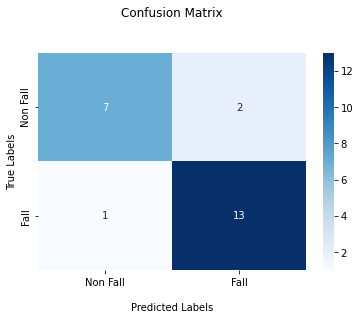

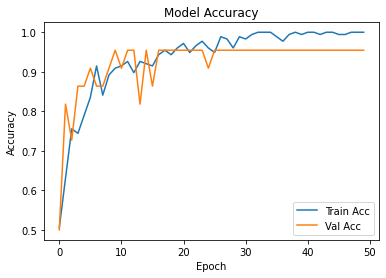

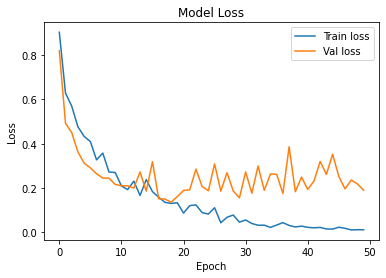

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

## Final Model

### VGG16 URFD

In [11]:
data,label = load_data('urfd')
x,y = extract_features_process_label(data,label,dataset_name='urfd',model='VGG16',classification='categorical')
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(x,y,train_size=0.6)
#model.summary()

In [12]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=16,n_epoch=20)

Epoch 1/20
4/4 [==============================] - 11s 267ms/step - loss: 0.8600 - accuracy: 0.4167 - val_loss: 0.4528 - val_accuracy: 0.8500
Epoch 2/20
4/4 [==============================] - 0s 30ms/step - loss: 0.6027 - accuracy: 0.6500 - val_loss: 0.3020 - val_accuracy: 1.0000
Epoch 3/20
4/4 [==============================] - 0s 28ms/step - loss: 0.4303 - accuracy: 0.8833 - val_loss: 0.2330 - val_accuracy: 0.9000
Epoch 4/20
4/4 [==============================] - 0s 50ms/step - loss: 0.2977 - accuracy: 0.9000 - val_loss: 0.1537 - val_accuracy: 1.0000
Epoch 5/20
4/4 [==============================] - 0s 33ms/step - loss: 0.2309 - accuracy: 0.9667 - val_loss: 0.1841 - val_accuracy: 0.9000
Epoch 6/20
4/4 [==============================] - 0s 32ms/step - loss: 0.2209 - accuracy: 0.9167 - val_loss: 0.1377 - val_accuracy: 0.9000
Epoch 7/20
4/4 [==============================] - 0s 28ms/step - loss: 0.1831 - accuracy: 0.9333 - val_loss: 0.0779 - val_accuracy: 1.0000
Epoch 8/20
4/4 [=========

              precision    recall  f1-score   support

    Non Fall       1.00      1.00      1.00         7
        Fall       1.00      1.00      1.00        13

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1Score:  1.0


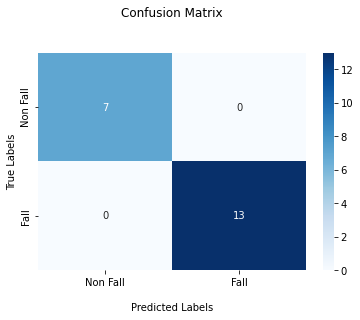

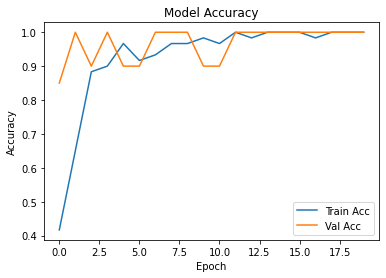

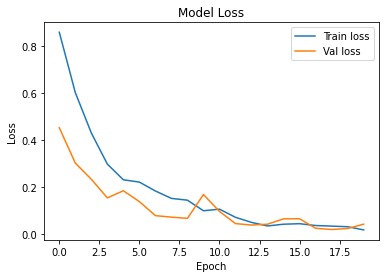

In [13]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

In [ ]:
model.save('drive/MyDrive/Final Model saved/urfd_vgg16.h5')

### VGG16 MCFD

In [14]:
data,label = load_data('mcfd')
x,y = extract_features_process_label(data,label,dataset_name='mcfd',model='VGG16',classification='categorical')
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(x,y,train_size=0.8)
#model.summary()

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=16,n_epoch=0)

Epoch 1/50
11/11 [==============================] - 6s 177ms/step - loss: 0.8823 - accuracy: 0.4830 - val_loss: 0.6115 - val_accuracy: 0.7273
Epoch 2/50
11/11 [==============================] - 0s 19ms/step - loss: 0.5870 - accuracy: 0.7045 - val_loss: 0.5895 - val_accuracy: 0.7273
Epoch 3/50
11/11 [==============================] - 0s 18ms/step - loss: 0.5586 - accuracy: 0.6932 - val_loss: 0.4321 - val_accuracy: 0.8182
Epoch 4/50
11/11 [==============================] - 0s 17ms/step - loss: 0.4361 - accuracy: 0.8352 - val_loss: 0.3715 - val_accuracy: 0.8636
Epoch 5/50
11/11 [==============================] - 0s 16ms/step - loss: 0.4234 - accuracy: 0.8239 - val_loss: 0.3177 - val_accuracy: 0.8182
Epoch 6/50
11/11 [==============================] - 0s 16ms/step - loss: 0.3885 - accuracy: 0.8352 - val_loss: 0.2781 - val_accuracy: 0.9091
Epoch 7/50
11/11 [==============================] - 0s 15ms/step - loss: 0.3620 - accuracy: 0.8409 - val_loss: 0.2797 - val_accuracy: 0.9091
Epoch 8/50
1

              precision    recall  f1-score   support

    Non Fall       0.88      0.78      0.82         9
        Fall       0.87      0.93      0.90        14

    accuracy                           0.87        23
   macro avg       0.87      0.85      0.86        23
weighted avg       0.87      0.87      0.87        23

Accuracy:  0.8695652173913043
Precision:  0.8666666666666667
Recall:  0.9285714285714286
F1Score:  0.896551724137931


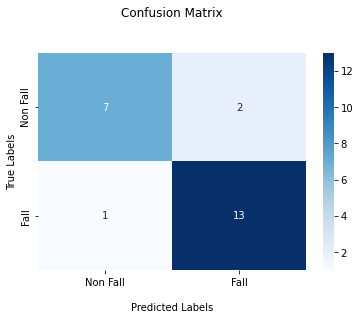

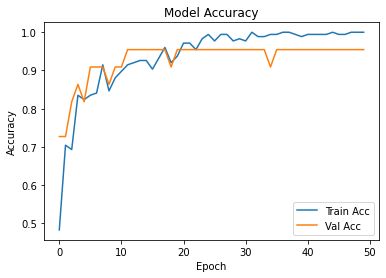

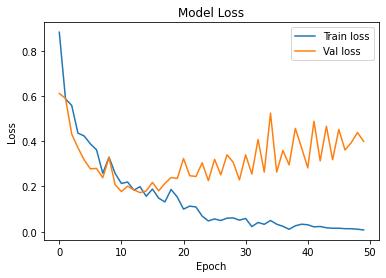

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

In [ ]:
model.save('drive/MyDrive/Final Model saved/mcfd_vgg16.h5')

### VGG19 URFD

In [ ]:
data,label = load_data('urfd')
x,y = extract_features_process_label(data,label,dataset_name='urfd',model='VGG19',classification='categorical')
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(x,y,train_size=0.6)
#model.summary()

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.0001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=16,n_epoch=50)

Epoch 1/50
4/4 [==============================] - 9s 258ms/step - loss: 0.7322 - accuracy: 0.5333 - val_loss: 0.3362 - val_accuracy: 0.8500
Epoch 2/50
4/4 [==============================] - 0s 24ms/step - loss: 0.5255 - accuracy: 0.7333 - val_loss: 0.2521 - val_accuracy: 1.0000
Epoch 3/50
4/4 [==============================] - 0s 24ms/step - loss: 0.4164 - accuracy: 0.8333 - val_loss: 0.2114 - val_accuracy: 1.0000
Epoch 4/50
4/4 [==============================] - 0s 24ms/step - loss: 0.3594 - accuracy: 0.8667 - val_loss: 0.1286 - val_accuracy: 1.0000
Epoch 5/50
4/4 [==============================] - 0s 23ms/step - loss: 0.2086 - accuracy: 0.9500 - val_loss: 0.0997 - val_accuracy: 1.0000
Epoch 6/50
4/4 [==============================] - 0s 26ms/step - loss: 0.2023 - accuracy: 0.9333 - val_loss: 0.0753 - val_accuracy: 1.0000
Epoch 7/50
4/4 [==============================] - 0s 23ms/step - loss: 0.0973 - accuracy: 1.0000 - val_loss: 0.1014 - val_accuracy: 1.0000
Epoch 8/50
4/4 [==========

              precision    recall  f1-score   support

    Non Fall       1.00      1.00      1.00         7
        Fall       1.00      1.00      1.00        13

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1Score:  1.0


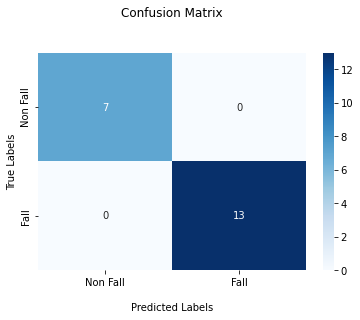

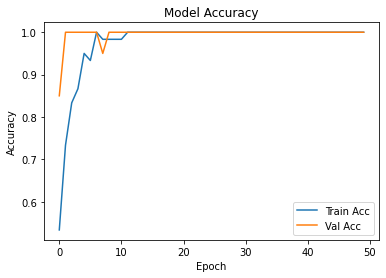

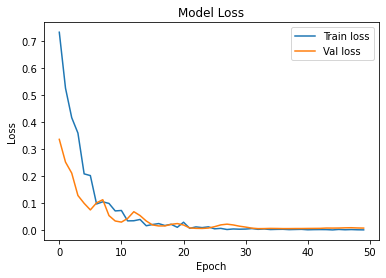

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

### VGG19 MCFD

In [ ]:
data,label = load_data('mcfd')
x,y = extract_features_process_label(data,label,dataset_name='mcfd',model='VGG19',classification='categorical')
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(x,y,train_size=0.8)
#model.summary()

In [ ]:
model = create_classification_model(input_shape=(16,4096),classes=2,m_type='bigru',n_neuron=256,activation='softmax')
model = compile_model(model,loss='categorical_crossentropy',optimizer='adam',learning_rate=0.00001)
history,model = train_model(model,x_train,x_val,y_train, y_val,batch_size=10,n_epoch=50)

Epoch 1/50
18/18 [==============================] - 11s 93ms/step - loss: 0.8110 - accuracy: 0.4716 - val_loss: 0.7452 - val_accuracy: 0.4091
Epoch 2/50
18/18 [==============================] - 0s 17ms/step - loss: 0.7041 - accuracy: 0.5625 - val_loss: 0.6848 - val_accuracy: 0.5000
Epoch 3/50
18/18 [==============================] - 0s 14ms/step - loss: 0.7377 - accuracy: 0.5000 - val_loss: 0.6302 - val_accuracy: 0.5455
Epoch 4/50
18/18 [==============================] - 0s 14ms/step - loss: 0.6491 - accuracy: 0.5966 - val_loss: 0.5972 - val_accuracy: 0.5455
Epoch 5/50
18/18 [==============================] - 0s 16ms/step - loss: 0.6464 - accuracy: 0.6193 - val_loss: 0.5973 - val_accuracy: 0.5909
Epoch 6/50
18/18 [==============================] - 0s 15ms/step - loss: 0.6747 - accuracy: 0.6080 - val_loss: 0.5551 - val_accuracy: 0.6818
Epoch 7/50
18/18 [==============================] - 0s 14ms/step - loss: 0.6442 - accuracy: 0.6477 - val_loss: 0.5421 - val_accuracy: 0.6818
Epoch 8/50
1

              precision    recall  f1-score   support

    Non Fall       0.88      0.78      0.82         9
        Fall       0.87      0.93      0.90        14

    accuracy                           0.87        23
   macro avg       0.87      0.85      0.86        23
weighted avg       0.87      0.87      0.87        23

Accuracy:  0.8695652173913043
Precision:  0.8666666666666667
Recall:  0.9285714285714286
F1Score:  0.896551724137931


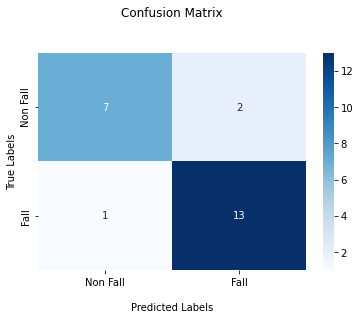

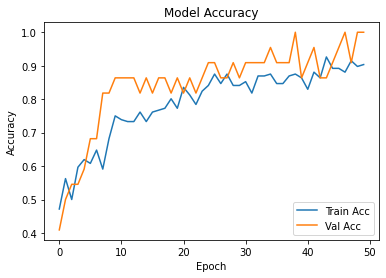

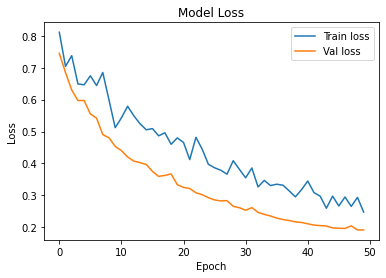

In [ ]:
y_pred = model.predict(x_test)
accuracy, cf, precision, recall, fscore = evaluate(y_test, y_pred, mode='categorical')
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ", recall)
print("F1Score: ", fscore)
cf_plot(y_test,y_pred, mode='categorical')
plot_history(history)

# TEst

In [ ]:
data,label = load_data('urfd')
x,y = extract_features_process_label(data,label,dataset_name='urfd',model='VGG19',classification='categorical')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Final Model saved/urfd_vgg16_1.h5')
model.evaluate(x,y)

4/4 [==============================] - 1s 10ms/step - loss: 0.1611 - accuracy: 0.9700


[0.16107963025569916, 0.9700000286102295]